In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from numpy.random import randn
np.random.seed(0)
import pickle
import gzip
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from geopy.distance import great_circle
from tqdm import tqdm

from hyperopt import fmin, tpe, hp, anneal, Trials

import time
from scipy.stats import norm
from scipy.signal import savgol_filter
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing
from sympy.utilities.codegen import codegen
init_printing(use_latex=True)

In [2]:
# data loading

data_ver = '3'

# NOISE
with gzip.open(f'../data/segment_with_noise_v{data_ver}/ll_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    ll_seg_noise = pickle.load(f)
with gzip.open(f'../data/segment_with_noise_v{data_ver}/rl_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    rl_seg_noise = pickle.load(f)

# GROUND TRUTH
with gzip.open(f'../data/segment_groud_truth_v2/rl_seg_gt_500_v2.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open(f'../data/segment_groud_truth_v2/ll_seg_gt_500_v2.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_noise))
print(ll_seg_noise[0].shape[0])
ll_seg_noise[0].head()

500
153


,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,omega_Zv,alpha_Xv,alpha_Yv,lane,y_noise,x_noise
68268,274.111469,109.920335,0.00,5.87,152.640,0.634,1.101,0.47,0.36,0.60,0.237,-0.150,1,274.552482,109.713725
68293,272.808525,110.598795,-0.01,5.88,152.633,0.648,1.087,-0.81,1.00,-0.26,0.212,-0.143,1,272.908564,110.574182
68318,271.504469,111.278905,0.00,5.90,152.626,0.677,1.130,-0.01,-0.45,-0.20,0.320,-0.018,1,271.749154,111.113036
68343,270.195971,111.961492,-0.01,5.91,152.607,0.720,1.148,-1.15,-0.40,0.47,0.242,-0.473,1,270.756194,112.243151
68368,268.884140,112.646555,-0.01,5.93,152.600,0.716,1.147,0.52,-0.02,-0.34,0.054,-0.277,1,269.351030,112.376572


In [3]:
# sample_freq = 50 # 5hz
sample_freq = 25 # 10hz
dt = 0.01 * sample_freq
dt

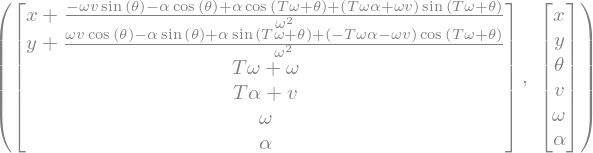

In [4]:
v, theta, omega, dts, x, y, lat, lon, alpha = symbols('v theta \omega T x y lat lon alpha')

# transition matrix
gs = Matrix([[x + (1 / omega**2) * ((v*omega + alpha * omega * dts) * sin(theta + omega * dts) + alpha * cos(theta + omega * dts) - v * omega * sin(theta) - alpha * cos(theta))],    
             [y + (1 / omega**2) * ((-v*omega - alpha * omega * dts) * cos(theta + omega * dts) + alpha * sin(theta + omega * dts) + v * omega * cos(theta) - alpha * sin(theta))],
             [omega + omega*dts],
             [alpha*dts + v],
             [omega],
             [alpha]])

# state vector             
state = Matrix([x, y, theta, v, omega, alpha])
gs, state

In [5]:
state

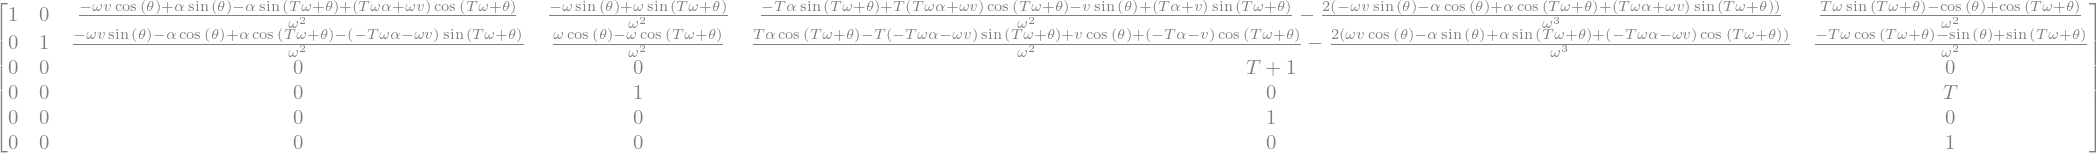

In [5]:
gs.jacobian(state)

## ekf_6states()

In [8]:
max_Vx = 6.5 # m/s
max_alpha_Vx = 2.193 # m/s2
max_omega_Zv = 1.56 # deg/s
max_omega_Zv_accel = 1 # deg/s2

s_gps = 0.5 * max_alpha_Vx * dt ** 2
s_yaw = 0.5 * max_omega_Zv * dt
s_vel = max_alpha_Vx * dt
s_omega = max_omega_Zv_accel * dt
s_accel = 0.05

sig_gps = 0.25
sig_theta = 0 * dt
sig_vel = 0 * dt
sig_omega = 1 * dt
sig_accel = 0

Q = np.diag([
    s_gps**2, s_gps**2, s_yaw**2, s_vel**2, s_omega**2, s_accel**2
])
Q

array([[0.00469653, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00469653, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.038025  , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.30057806, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.0625    ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.0025    ]])

In [6]:
def ekf_6_states(segment_df, param, filter_flag):

    # constants definition
    max_Vx = 6.5 # m/s
    max_alpha_Vx = 2.193 # m/s2
    max_omega_Zv = 1.56 # deg/s
    max_omega_Zv_accel = 0.5 # 1 # deg/s2

    s_gps = 0.5 * max_alpha_Vx * dt ** 2
    s_yaw = 0.001 * dt # max_omega_Zv * dt
    s_vel = max_alpha_Vx * dt
    s_omega = max_omega_Zv_accel * dt
    s_accel = 0.25

    sig_gps = 0.25
    sig_theta = 0.1
    sig_vel = 0 * dt
    sig_omega = 0.01
    sig_accel = 0

    x_noise = segment_df['x_noise'].values
    y_noise = segment_df['y_noise'].values
    Vx = segment_df['Vx'].values
    theta = segment_df['theta'].values/180.0*np.pi             # rad

    if filter_flag:
        omega_Zv = savgol_filter(segment_df['omega_Zv'].values/180.0*np.pi, 32, 4)       # rad/s
        alpha_Xv = savgol_filter(segment_df['alpha_Xv'].values, 32, 4)
    else:
        omega_Zv = segment_df['omega_Zv'].values/180.0*np.pi       # rad/s
        alpha_Xv = segment_df['alpha_Xv'].values

    # set initial values
    x = np.matrix([
        x_noise[0], y_noise[0], theta[0], Vx[0], omega_Zv[0], alpha_Xv[0]
    ]).T

    observations = np.vstack((
        x_noise, y_noise, Vx, omega_Zv, alpha_Xv
    ))

    if param is None:
        P = 1 * np.eye(len(state))
        # process noise covariance Q matrix
        Q = np.diag([
            s_gps**2, s_gps**2, s_yaw**2, s_vel**2, s_omega**2, s_accel**2
        ])
        R = np.diag(
            [sig_gps**2, sig_gps**2, sig_vel**2, sig_omega**2, sig_accel**2]
        )
    else:
        P = param['p_diag'] * np.eye(len(state))
        Q = np.diag([
            param['q11'], param['q11'], param['q33'], param['q44'], param['q55'], param['q66']
        ])

        try:
            R = np.diag(
                [sig_gps**2, sig_gps**2, sig_vel**2, param['r44'], param['r55']]         
            )
        except:
            R = np.diag(
                [sig_gps**2, sig_gps**2, sig_vel**2, sig_omega**2, sig_accel**2]
            )
        

    """ Q = np.diag([
        s_gps**2, s_gps**2, 0.0002, s_vel**2, 0.0002, s_accel**2
    ]) """

    """ Q = np.array([
        [s_gps**2, 0, 0.0001, 0.0001, 0.0001, 0.0001],
        [0, s_gps**2, 0.0001, 0.0001, 0.0001, 0.0001],
        [0, 0, s_yaw**2, 0.0001, 0.0001, 0.0001],
        [0, 0, 0.0001, 0.0001, s_vel**2, 0.0001],
        [0, 0, 0.0001, 0.0001, s_omega**2, 0],
        [0, 0, 0.0001, 0.0001, 0, s_accel**2],
    ]) """

    I = np.eye(len(state))

    # measurement function, H
    H = np.array([
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    ])

    m = observations.shape[1]
    nx = Q.shape[0]
    ny = R.shape[0]
    x_est = np.zeros((m, nx))      # prediction of state vector                                                       

    for filterstep in np.arange(m):
        
        if np.abs(omega_Zv[filterstep])<0.0001: # Driving straight
            x[4] = 0.0001

        if filterstep > 0:
            # state transition
            x[0] = x[0] + (1 / x[4]**2) * ((x[3]*x[4] + x[5] * x[4] * dt) * \
                np.sin(x[2] + x[4]* dt) + x[5] * np.cos(x[2] + x[4] * dt) - x[3] *  \
                x[4] * np.sin(x[2]) - x[5] * np.cos(x[2]))
            x[1] = x[1] + (1 / x[4]**2) * ((-x[3]*x[4] - x[5] * x[4] * dt) * \
                np.cos(x[2] + x[4]* dt) + x[5] * np.sin(x[2] + x[4] * dt) + x[3] * \
                x[4] * np.cos(x[2]) - x[5] * np.sin(x[2]))
            x[2] = (x[2] + x[4] * dt + np.pi) % (2.0 * np.pi) - np.pi
            x[3] = x[3] + x[5] * dt 
            x[4] = x[4]
            x[5] = x[5]
        
        
        # Calculate the Jacobian of the Dynamic Matrix A
        a13 = ((-x[4]*x[3]*np.cos(x[2]) + x[5]*np.sin(x[2]) - x[5]*np.sin(dt*x[4] + x[2]) + \
            (dt*x[4]*x[5] + x[4]*x[3])*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)

        a14 = ((-x[4]*np.sin(x[2]) + x[4]*np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)

        a15 = ((-dt*x[5]*np.sin(dt*x[4] + x[2]) + dt*(dt*x[4]*x[5] + x[4]*x[3])* \
            np.cos(dt*x[4] + x[2]) - x[3]*np.sin(x[2]) + (dt*x[5] + x[3])* \
            np.sin(dt*x[4] + x[2]))/x[4]**2 - 2*(-x[4]*x[3]*np.sin(x[2]) - x[5]* \
            np.cos(x[2]) + x[5]*np.cos(dt*x[4] + x[2]) + (dt*x[4]*x[5] + x[4]*x[3])* \
            np.sin(dt*x[4] + x[2]))/x[4]**3).item(0)

        a16 = ((dt*x[4]*np.sin(dt*x[4] + x[2]) - np.cos(x[2]) + np.cos(dt * x[4] + x[2]))/x[4]**2).item(0)

        a23 = ((-x[4] * x[3] * np.sin(x[2]) - x[5] * np.cos(x[2]) + x[5] * np.cos(dt * x[4] + x[2]) - \
            (-dt * x[4]*x[5] - x[4] * x[3]) * np.sin(dt * x[4] + x[2])) / x[4]**2).item(0)
        a24 = ((x[4] * np.cos(x[2]) - x[4]*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)
        a25 = ((dt * x[5]*np.cos(dt*x[4] + x[2]) - dt * (-dt*x[4]*x[5] - x[4] * x[3]) * \
            np.sin(dt * x[4] + x[2]) + x[3]*np.cos(x[2]) + (-dt*x[5] - x[3])*np.cos(dt*x[4] + x[2]))/ \
            x[4]**2 - 2*(x[4]*x[3]*np.cos(x[2]) - x[5] * np.sin(x[2]) + x[5] * np.sin(dt*x[4] + x[2]) + \
            (-dt * x[4] * x[5] - x[4] * x[3])*np.cos(dt*x[4] + x[2]))/x[4]**3).item(0)
        a26 =  ((-dt*x[4]*np.cos(dt*x[4] + x[2]) - np.sin(x[2]) + np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)
            
        JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                        [0.0, 1.0, a23, a24, a25, a26],
                        [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
        
        
        # Project the error covariance ahead
        P = JA * P * JA.T + Q
        
        # Measurement Update (Correction)
        # ===============================
        # Measurement Function
        hx = np.matrix([[float(x[0])],
                        [float(x[1])],
                        [float(x[3])],
                        [float(x[4])],
                        [float(x[5])]])        
        
        S = H * P * H.T + R
        K = (P * H.T) * np.linalg.inv(S)

        # Update the estimate via
        Z = observations[:, filterstep].reshape(H.shape[0], 1)
        y = Z - (hx) # innovation or residual
        x = x + (K * y) # update estimated state

        # Update the error covariance
        P = (I - (K * H)) * P

        x_est[filterstep] = x.T

    return x_est, x_noise, y_noise, segment_df['x'].values, segment_df['y'].values

### sample estimation

In [9]:
sample_idx = 201
sample_traj = ll_seg_noise[sample_idx]
sample_traj.head()

,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,omega_Zv,alpha_Xv,alpha_Yv,lane,y_noise,x_noise
22302,717.822536,1209.676767,-0.02,5.24,357.536,0.891,2.125,-1.02,-0.29,0.06,0.124,-0.397,1,717.876258,1209.933827
22327,719.128814,1209.618994,-0.01,5.23,357.499,0.923,2.112,-0.42,-0.06,0.06,0.076,-0.426,1,719.091238,1209.485545
22352,720.433981,1209.558746,-0.01,5.22,357.482,0.980,2.045,-0.38,0.43,-0.08,0.135,-0.345,1,720.023939,1209.522587
22377,721.736926,1209.498497,-0.02,5.22,357.453,1.023,1.993,-0.27,0.64,-0.11,0.243,-0.361,1,721.614922,1209.252199
22402,723.040982,1209.438248,-0.01,5.22,357.416,0.997,1.927,-0.27,0.27,-0.29,0.146,-0.349,1,723.069575,1209.427037


In [198]:
(350/180*np.pi + np.pi) % (2*np.pi) - np.pi

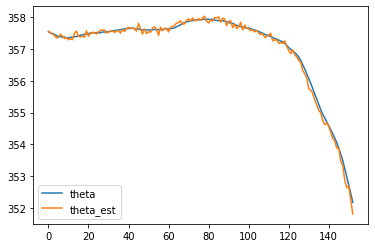

In [134]:
plt.plot(sample_traj['theta'].values, label='theta')
plt.plot(
    sample_traj['theta'].values + sample_traj['omega_Zv'].values * dt , label='theta_est'
    )
plt.legend()

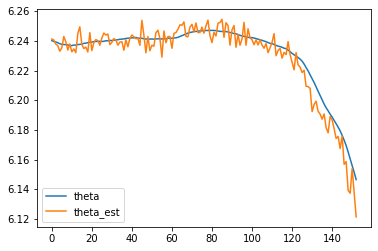

In [121]:
plt.plot(sample_traj['theta'].values/180.0*np.pi, label='theta')
plt.plot(
    (sample_traj['theta'].values/180.0*np.pi + sample_traj['omega_Zv'].values/180.0*np.pi), label='theta_est'
    )
plt.legend()

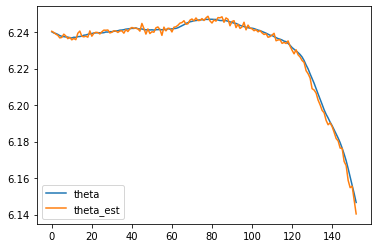

In [119]:
plt.plot(sample_traj['theta'].values/180.0*np.pi, label='theta')
plt.plot(
    (sample_traj['theta'].values/180.0*np.pi  + sample_traj['omega_Zv'].values/180.0*np.pi * dt + np.pi) % \
    (2 * np.pi) + np.pi, label='theta_est'
    )
plt.legend()

### scratch work

In [78]:
# P0 matrix
P = 5 * np.eye(len(state))
print(P, P.shape)
print()

max_Vx = 6.5 # m/s
max_alpha_Vx = 2.193 # m/s2
max_omega_Zv = 1.56 # deg/s
max_omega_Zv_accel = 1 # deg/s2

s_gps = 0.5 * max_alpha_Vx * dt ** 2
s_yaw = max_omega_Zv * dt
s_vel = max_Vx * dt
s_omega = 1.0 * dt
s_accel = max_alpha_Vx * 0.5

sig_gps = 2
sig_theta = 0*dt
sig_vel = 3*dt
sig_omega = 0*dt
sig_accel = 1
sig_yaw_rate = 0.1

# Process noise covariance Q matrix
# assume the processes are indepedent of each other
Q = np.diag([
    s_gps**2, s_gps**2, s_yaw**2, s_vel**2, s_omega**2, s_accel**2
])

print(Q, Q.shape)
print()

# Measurement covariance R matrix

R = np.diag(
    [sig_gps**2, sig_gps**2, sig_vel**2, sig_yaw_rate**2, sig_accel**2]
)
print(R, R.shape)

I = np.eye(len(state))

# measurement function, H

H = np.array([
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
])

[[5. 0. 0. 0. 0. 0.]
 [0. 5. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0.]
 [0. 0. 0. 5. 0. 0.]
 [0. 0. 0. 0. 5. 0.]
 [0. 0. 0. 0. 0. 5.]] (6, 6)

[[0.00469653 0.         0.         0.         0.         0.        ]
 [0.         0.00469653 0.         0.         0.         0.        ]
 [0.         0.         0.1521     0.         0.         0.        ]
 [0.         0.         0.         2.640625   0.         0.        ]
 [0.         0.         0.         0.         0.0625     0.        ]
 [0.         0.         0.         0.         0.         1.20231225]] (6, 6)

[[4.     0.     0.     0.     0.    ]
 [0.     4.     0.     0.     0.    ]
 [0.     0.     0.5625 0.     0.    ]
 [0.     0.     0.     0.01   0.    ]
 [0.     0.     0.     0.     1.    ]] (5, 5)


In [52]:
x_est_sample, x_noise, y_noise, x, y = ekf_6_stats(sample_traj)

In [79]:
# measurements

x_noise = sample_traj['x_noise'].values
y_noise = sample_traj['y_noise'].values
Vx = sample_traj['Vx'].values
alpha_Xv = sample_traj['alpha_Xv'].values
theta = sample_traj['theta'].values/180.0*np.pi             # rad
omega_Zv = sample_traj['omega_Zv'].values/180.0*np.pi       # rad/s

x = np.matrix([
    x_noise[0], y_noise[0], theta[0], Vx[0], np.average(omega_Zv), np.average(alpha_Xv)
]).T

observations = np.vstack((
    x_noise, y_noise, Vx, omega_Zv, alpha_Xv
))

m = observations.shape[1]
print(observations.shape[1])

# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Pdv =[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kdv= []
dstate=[]

153


In [81]:
for filterstep in range(m):

    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    
    # if np.abs(observations[2][filterstep]) < 0.0001: # Driving straight
    #     x[4] = 0.0001
    
    x[0] = x[0] + (1 / x[4]**2) * ((x[3]*x[4] + x[5] * x[4] * dt) * \
        np.sin(x[2] + x[4]* dt) + x[5] * np.cos(x[2] + x[4] * dt) - x[3] *  \
        x[4] * np.sin(x[2]) - x[5] * np.cos(x[2]))
    x[1] = x[1] + (1 / x[4]**2) * ((-x[3]*x[4] - x[5] * x[4] * dt) * \
        np.cos(x[2] + x[4]* dt) + x[5] * np.sin(x[2] + x[4] * dt) + x[3] * \
        x[4] * np.cos(x[2]) - x[5] * np.sin(x[2]))
    x[2] = (x[2] + x[4] * dt)#  + np.pi) % (2.0 * np.pi) - np.pi
    x[3] = x[3] + x[5] * dt 
    x[4] = x[4]
    x[5] = x[5]
    
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a13 = ((-x[4]*x[3]*np.cos(x[2]) + x[5]*np.sin(x[2]) - x[5]*np.sin(dt*x[4] + x[2]) + \
        (dt*x[4]*x[5] + x[4]*x[3])*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)

    a14 = ((-x[4]*np.sin(x[2]) + x[4]*np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)

    a15 = ((-dt*x[5]*np.sin(dt*x[4] + x[2]) + dt*(dt*x[4]*x[5] + x[4]*x[3])* \
        np.cos(dt*x[4] + x[2]) - x[3]*np.sin(x[2]) + (dt*x[5] + x[3])* \
        np.sin(dt*x[4] + x[2]))/x[4]**2 - 2*(-x[4]*x[3]*np.sin(x[2]) - x[5]* \
        np.cos(x[2]) + x[5]*np.cos(dt*x[4] + x[2]) + (dt*x[4]*x[5] + x[4]*x[3])* \
        np.sin(dt*x[4] + x[2]))/x[4]**3).item(0)

    a16 = ((dt*x[4]*np.sin(dt*x[4] + x[2]) - np.cos(x[2]) + np.cos(dt * x[4] + x[2]))/x[4]**2).item(0)

    a23 = ((-x[4] * x[3] * np.sin(x[2]) - x[5] * np.cos(x[2]) + x[5] * np.cos(dt * x[4] + x[2]) - \
        (-dt * x[4]*x[5] - x[4] * x[3]) * np.sin(dt * x[4] + x[2])) / x[4]**2).item(0)
    a24 = ((x[4] * np.cos(x[2]) - x[4]*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)
    a25 = ((dt * x[5]*np.cos(dt*x[4] + x[2]) - dt * (-dt*x[4]*x[5] - x[4] * x[3]) * \
        np.sin(dt * x[4] + x[2]) + x[3]*np.cos(x[2]) + (-dt*x[5] - x[3])*np.cos(dt*x[4] + x[2]))/ \
        x[4]**2 - 2*(x[4]*x[3]*np.cos(x[2]) - x[5] * np.sin(x[2]) + x[5] * np.sin(dt*x[4] + x[2]) + \
        (-dt * x[4] * x[5] - x[4] * x[3])*np.cos(dt*x[4] + x[2]))/x[4]**3).item(0)
    a26 =  ((-dt*x[4]*np.cos(dt*x[4] + x[2]) - np.sin(x[2]) + np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)
        
    JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                    [0.0, 1.0, a23, a24, a25, a26],
                    [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    
    # Project the error covariance ahead
    P = JA * P * JA.T + Q
    
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])]])        
    
    S = H * P * H.T + R
    K = (P * H.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = observations[:,filterstep].reshape(H.shape[0],1)
    y = Z - (hx)                         # Innovation or Residual
    x = x + (K * y)

    # Update the error covariance
    P = (I - (K * H)) * P


    # Save states for Plotting
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pdv.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kdv.append(float(K[5,0]))

### plotting helper functions

In [7]:
def plot_traj_comp(x_est, y_est, x_noise, y_noise, x, y, sample_idx, exp_name=''):

    plt.figure(dpi=100, figsize=(7, 4))

    # EKF State
    plt.plot(x_est, y_est, label='ekf_6states prediction', c='green', lw=2)

    # ground truth
    plt.plot(x, y, label='ground truth, 10hz', c='blue', lw=2, alpha=0.75)

    # Measurements
    plt.scatter(x_noise, y_noise, s=30, label='GPS noise, 10hz', marker='+', alpha=0.75, c='orange')

    # Start/Goal
    plt.scatter(x[0], y[0], s=75, label='start', c='g')
    plt.scatter(x[-1], y[-1], s=75, label='end', c='r')

    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title(f'sample [{sample_idx}]')
    plt.legend(loc='best')
    plt.show()

In [8]:
def plot_traj_comp_idx(ekf_results, sample_idx, exp_name=''):

    plt.figure(dpi=100, figsize=(7, 4))
    ekf_result = ekf_results[sample_idx]

    x_est = ekf_result['x_est'].values
    y_est = ekf_result['y_est'].values

    x = ekf_result['x'].values
    y = ekf_result['y'].values

    x_noise = ekf_result['x_noise'].values
    y_noise = ekf_result['y_noise'].values

    # EKF State
    plt.plot(x_est, y_est, label='ekf_6states prediction', c='green', lw=2)

    # ground truth
    plt.plot(x, y, label='ground truth, 10hz', c='blue', lw=2, alpha=0.75)

    # Measurements
    plt.scatter(x_noise, y_noise, s=30, label='GPS noise, 10hz', marker='+', alpha=0.75, c='orange')

    # Start/Goal
    plt.scatter(x[0], y[0], s=75, label='start', c='g')
    plt.scatter(x[-1], y[-1], s=75, label='end', c='r')

    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title(f'sample [{sample_idx}]: {exp_name}')
    plt.legend(loc='best')
    plt.show()

## single segment estimation

In [200]:
x_est_sample, x_noise, y_noise, x, y = ekf_6_stats(sample_traj)
print(x_est_sample.shape, x_noise.shape)

(153, 6) (153,)


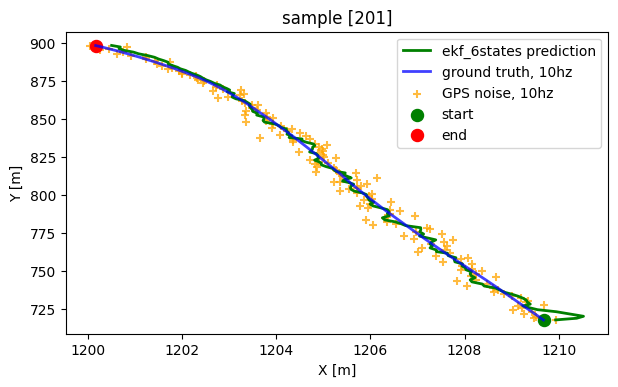

In [201]:
plot_traj_comp(
    x_est_sample[:, 0], x_est_sample[:, 1],
    sample_traj['x_noise'].values, sample_traj['y_noise'].values,
    sample_traj['x'].values, sample_traj['y'].values,
    sample_idx=sample_idx
)

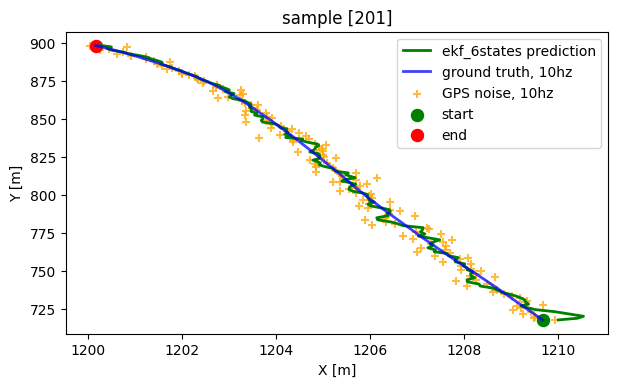

In [348]:
plot_traj_comp(
    x_est_sample[:, 0], x_est_sample[:, 1],
    sample_traj['x_noise'].values, sample_traj['y_noise'].values,
    sample_traj['x'].values, sample_traj['y'].values,
    sample_idx=sample_idx
)

Text(0.5, 0, 'Filter Step')

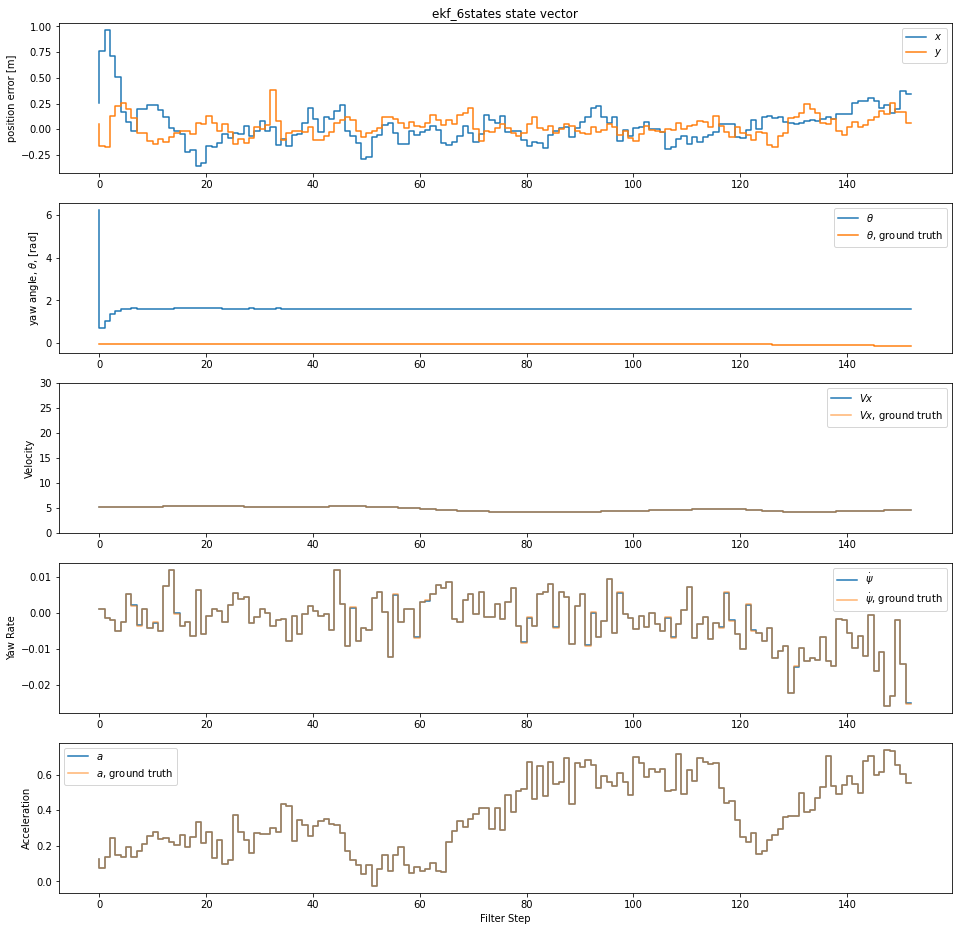

In [202]:
fig = plt.figure(figsize=(16, 16))
steps = range(x_est_sample.shape[0])

plt.subplot(511)
plt.step(steps, x_est_sample[:, 0]-sample_traj['x'].values, label='$x$')
plt.step(steps, x_est_sample[:, 1]-sample_traj['y'].values, label='$y$')

plt.title('ekf_6states state vector')
plt.legend(loc='best')
plt.ylabel('position error [m]')

plt.subplot(512)
plt.step(steps, x_est_sample[:, 2], label=r'$\theta$')
plt.step(steps, (sample_traj['theta'].values /180.0*np.pi+np.pi)%(2.0*np.pi) - np.pi, label=r'$\theta$, ground truth')
plt.ylabel(r'yaw angle, $\theta$, [rad]')
plt.legend(loc='best')
           
plt.subplot(513)
plt.step(steps, x_est_sample[:, 3], label='$Vx$')
plt.step(steps, sample_traj['Vx'].values, label='$Vx$, ground truth', alpha=0.6)
plt.ylabel('Velocity')
plt.ylim([0, 30])
plt.legend(loc='best')

plt.subplot(514)
plt.step(steps, x_est_sample[:, 4], label='$\dot \psi$')
plt.step(steps, sample_traj['omega_Zv'].values / 180.0 * np.pi, label='$\dot \psi$, ground truth', alpha=0.6)
plt.ylabel('Yaw Rate')
# plt.ylim([-0.6, 0.6])
plt.legend(loc='best')

plt.subplot(515)
plt.step(steps, x_est_sample[:, 5], label='$a$')
plt.step(steps, sample_traj['alpha_Xv'].values, label='$a$, ground truth', alpha=0.6)
plt.ylabel('Acceleration')
#plt.ylim([-0.6, 0.6])
plt.legend(loc='best')
plt.xlabel('Filter Step')

# plt.savefig('Extended-Kalman-Filter-CTRA-State-Estimates.png', dpi=72, transparent=True, bbox_inches='tight')

### error metrics

In [15]:
def traj_distances_proj(df):

    """
    trajectory distance after projection
    """

    length_m = 0
    length_m_pred = 0
    length_m_noise = 0

    for index, row in df.iterrows():
        try:
            # actual
            start = (row['y'], row['x'])
            end = (df.iloc[index+1]['y'], df.iloc[index+1]['x'])
            length_m += math.dist(start, end)

            # predicted
            start = (row['y_est'], row['x_est'])
            end = (df.iloc[index+1]['y_est'], df.iloc[index+1]['x_est'])
            length_m_pred += math.dist(start, end)

            # noise
            start = (row['y_noise'], row['x_noise'])
            end = (df.iloc[index+1]['y_noise'], df.iloc[index+1]['x_noise'])
            length_m_noise += math.dist(start, end)

        except: # end of trajectory
            pass
    
    return length_m, length_m_pred, length_m_noise

In [16]:
def plot_tot_traj_dist_err(traj_seg_pred, exp_name):

    length_m_lst = []
    length_m_pred_lst = []
    length_m_noise_lst = []

    for idx, df in enumerate(traj_seg_pred):
        length_m, length_m_pred, length_m_noise = traj_distances_proj(df)
        length_m_lst.append(length_m)
        length_m_pred_lst.append(length_m_pred)
        length_m_noise_lst.append(length_m_noise)
    
    plt.figure(figsize=((7, 4)), dpi=100)
    sns.histplot(np.array(length_m_lst) - np.array(length_m_pred_lst), binwidth=0.25, label='truth - pred')
    sns.histplot(np.array(length_m_lst) - np.array(length_m_noise_lst), binwidth=0.25, label='truth - noise', color='red')
    plt.title(f'ekf_6state: {exp_name}')
    plt.xlabel('total trajectory length error [m]')
    # plt.xlim(-15, 1)
    plt.ylim(0, 20)
    plt.legend()

In [21]:
def proj_dist_err(ekf_results):

    proj_dist_err_pred_lst = []
    proj_dist_err_noise_lst = []

    for seg_df in ekf_results:
        traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
        traj_noise = np.array([seg_df['x_noise'].values, seg_df['y_noise'].values])
        traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])

        for i in np.arange(seg_df.shape[0]):
            est_coord = (traj_est[0][i], traj_est[1][i])
            gt_noise = (traj_noise[0][i], traj_noise[1][i])
            gt_coord = (traj_gt[0][i], traj_gt[1][i])
            
            proj_dist_err_pred_lst.append(math.dist(est_coord, gt_coord))
            proj_dist_err_noise_lst.append(math.dist(gt_noise, gt_coord))
    
    return proj_dist_err_pred_lst, proj_dist_err_noise_lst

In [18]:
def plot_proj_dist_err(pred_err, noise_err, exp_name):

    plt.figure(figsize=(7,4), dpi=100)
    ax = sns.histplot(
        noise_err,
        binwidth=0.02, label='spatial noise', color='red', kde=True)
    sns.histplot(
        pred_err, 
        binwidth=0.02, label='ekf_6states pred error', kde=True)

    ax.axvline(np.median(noise_err), color='k', lw=2, label='noise: median')
    ax.axvline(np.nanmedian(np.array(pred_err)), color='red', ls='--', lw=2, label='ekf_6states: median')

    plt.title(f'ekf_6states: {exp_name}')
    plt.xlabel('error distance [m]')
    # plt.ylim([0, 250])
    plt.xlim([-0.1, 1.2])
    plt.legend()
    plt.show()

In [19]:
def boxplot_proj_dist_err(pred_err, noise_err, exp_name):

    plt.figure(figsize=(7, 3), dpi=100)
    ax = sns.boxplot(data=[
        pred_err, noise_err
    ], orient='h')
    ax.set_xlim(0, 7)
    ax.set_yticks([0, 1], ['prediction error', 'noise error'])
    plt.title(f'ekf_6states boxplot: {exp_name}')
    plt.xlabel('coord euclidean error [m]')

In [349]:
# rmse
traj_est_sample = np.array([
    x_est_sample[:, 0], x_est_sample[:, 1]
])
traj_ground_truth = np.array([
    sample_traj['x'].values, sample_traj['y'].values
])

np.sqrt(mean_squared_error(traj_est_sample, traj_ground_truth))

## sample batch estimation

#### ekf_batch_eval()

In [37]:
def ekf_batch_eval(batch_df, param, filter_flag=False):

    seg_pred_batch = []

    for df_idx, df in enumerate(batch_df):
        try:
            x_est_sample, x_noise, y_noise, x, y = ekf_6_states(df, param, filter_flag)
            x_est_df = pd.DataFrame({
                'x_est': x_est_sample[:, 0],
                'y_est': x_est_sample[:, 1],
                'theta': x_est_sample[:, 2],
                'Vx_est': x_est_sample[:, 3],
                'x_noise': x_noise,
                'y_noise': y_noise,
                'x': x,
                'y': y
                }
            )
            seg_pred_batch.append(x_est_df)
        except:
            print(df_idx)
    
    return seg_pred_batch

In [24]:
best

{'q11': 0.0047450756317065955,
 'q33': 0.016508690614930665,
 'q44': 0.20811258834653795,
 'q55': 0.04812402263849899,
 'q66': 0.11103271026765318}

In [37]:
# subsample for parameter learning
random.seed(0)
sample_trajs = random.sample(rl_seg_noise, 50)
len(sample_trajs)

In [38]:
# original
seg_pred_batch = ekf_batch_eval(sample_trajs, Q=None, P_diag=None)

rmse_lst = []

for seg_df in seg_pred_batch:
    traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
    traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])

    rmse_lst.append(np.sqrt(mean_squared_error(traj_est, traj_gt)))

np.average(rmse_lst)

In [200]:
pred_err = []
noise_err = []

for j in np.arange(len(seg_pred_batch)):

    x_gt = seg_pred_batch[j]['x'].values
    y_gt = seg_pred_batch[j]['y'].values
    x_est = seg_pred_batch[j]['x_est'].values
    y_est = seg_pred_batch[j]['y_est'].values
    x_noise = seg_pred_batch[j]['x_noise'].values
    y_noise = seg_pred_batch[j]['y_noise'].values

    for i in np.arange(seg_pred_batch[0].shape[0]):
        pred_coord = (x_est[i], y_est[i])
        gt_coord = (x_gt[i], y_gt[i])
        noise_coord = (x_noise[i], y_noise[i])
        
        pred_err.append(math.dist(pred_coord, gt_coord)) # meter
        noise_err.append(math.dist(noise_coord, gt_coord)) # meter

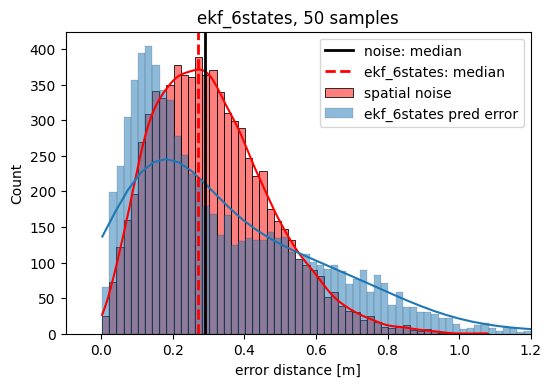

In [196]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    binwidth=0.02, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    binwidth=0.02, label='ekf_6states pred error', kde=True)

ax.axvline(np.median(noise_err), color='k', lw=2, label='noise: median')
ax.axvline(np.nanmedian(np.array(pred_err)), color='red', ls='--', lw=2, label='ekf_6states: median')

plt.title('ekf_6states, 50 samples')
plt.xlabel('error distance [m]')
plt.xlim([-0.1, 1.2])
plt.legend()
plt.show()

Text(0.5, 0, 'ekf_6states, 50 samples, pred error')

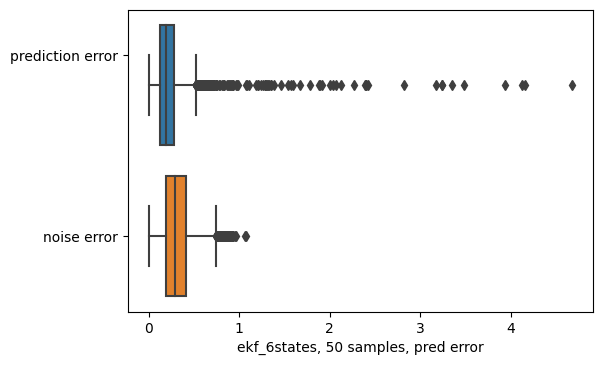

In [217]:
ax = sns.boxplot(data=[
    pred_err, noise_err
], orient='h')
ax.set_yticks([-0.2, 1], ['prediction error', 'noise error'])
plt.xlabel('ekf_6states, 50 samples, pred error')

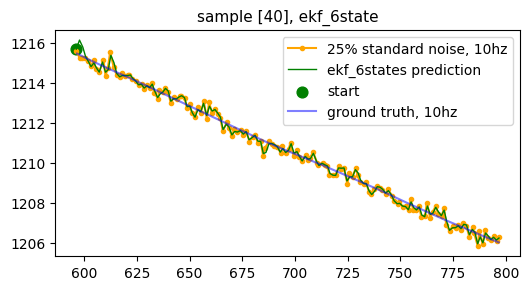

In [216]:
sample = 40
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(seg_pred_batch[sample]['y_noise'], seg_pred_batch[sample]['x_noise'], '-o', label='25% standard noise, 10hz', ms=3, c='orange')
plt.plot(seg_pred_batch[sample]['y_est'], seg_pred_batch[sample]['x_est'], '-', linewidth=1, label='ekf_6states prediction', c='green')
plt.scatter(seg_pred_batch[sample]['y_est'][0], seg_pred_batch[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(seg_pred_batch[sample]['y'], seg_pred_batch[sample]['x'], label='ground truth, 10hz', c='blue', alpha=0.5)
plt.title(f'sample [{sample}], ekf_6state', fontsize=11)
plt.legend()
plt.show()

In [218]:
Q = np.diag([
    best['q11'], best['q11'], best['q33'], best['q44'], best['q55'], best['q66']
])

seg_pred_batch = ekf_batch_eval(Q, sample_trajs)

rmse_lst = []

for seg_df in seg_pred_batch:
    traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
    traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])

    rmse_lst.append(np.sqrt(mean_squared_error(traj_est, traj_gt)))

np.average(rmse_lst)

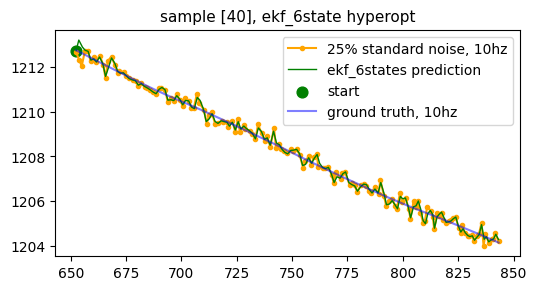

In [219]:
sample = 40
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(seg_pred_batch[sample]['y_noise'], seg_pred_batch[sample]['x_noise'], '-o', label='25% standard noise, 10hz', ms=3, c='orange')
plt.plot(seg_pred_batch[sample]['y_est'], seg_pred_batch[sample]['x_est'], '-', linewidth=1, label='ekf_6states prediction', c='green')
plt.scatter(seg_pred_batch[sample]['y_est'][0], seg_pred_batch[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(seg_pred_batch[sample]['y'], seg_pred_batch[sample]['x'], label='ground truth, 10hz', c='blue', alpha=0.5)
plt.title(f'sample [{sample}], ekf_6state hyperopt', fontsize=11)
plt.legend()
plt.show()

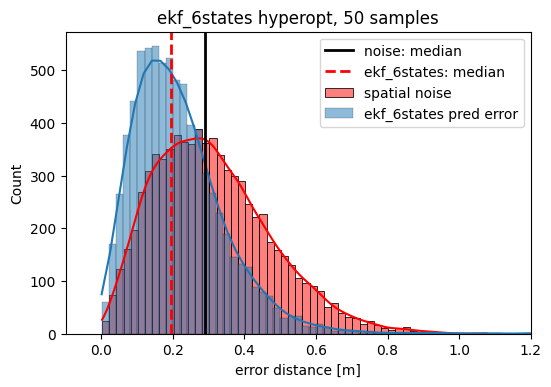

In [201]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    binwidth=0.02, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    binwidth=0.02, label='ekf_6states pred error', kde=True)

ax.axvline(np.median(noise_err), color='k', lw=2, label='noise: median')
ax.axvline(np.nanmedian(np.array(pred_err)), color='red', ls='--', lw=2, label='ekf_6states: median')

plt.title('ekf_6states hyperopt, 50 samples')
plt.xlabel('error distance [m]')
plt.xlim([-0.1, 1.2])
plt.legend()
plt.show()

Text(0.5, 0, 'ekf_6states hyeropt, 50 samples, pred error')

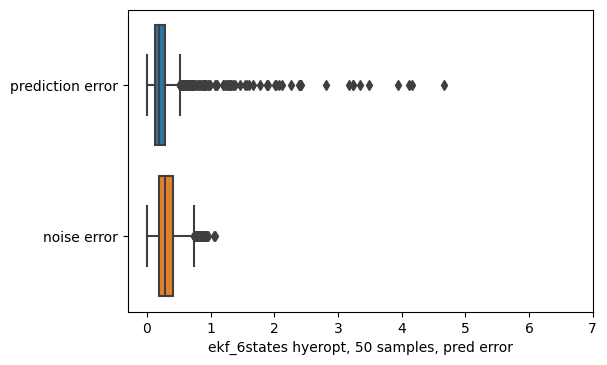

In [207]:
ax = sns.boxplot(data=[
    pred_err, noise_err
], orient='h')
ax.set_xlim([-0.3, 7])
ax.set_yticks([0, 1], ['prediction error', 'noise error'])
plt.xlabel('ekf_6states hyeropt, 50 samples, pred error')

### batch estimation

In [329]:
# runtime ~= 2min
# list of dataframe
rl_seg_pred = []

for df in rl_seg_noise:
    x_est_sample, x_noise, y_noise, x, y = ekf_6_stats(df, param=None)
    x_est_df = pd.DataFrame({
        'x_est': x_est_sample[:, 0],
        'y_est': x_est_sample[:, 1],
        'theta': x_est_sample[:, 2],
        'Vx_est': x_est_sample[:, 3],
        'x_noise': x_noise,
        'y_noise': y_noise,
        'x': x,
        'y': y
        }
    )
    rl_seg_pred.append(x_est_df)

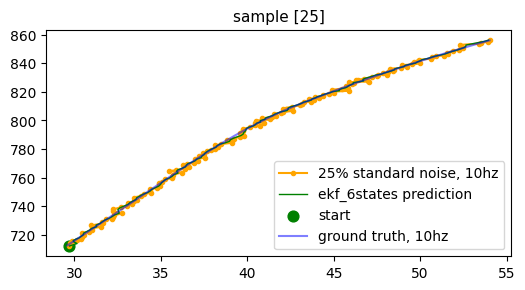

In [330]:
sample = 25
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(rl_seg_pred[sample]['y_noise'], rl_seg_pred[sample]['x_noise'], '-o', label='25% standard noise, 10hz', ms=3, c='orange')
plt.plot(rl_seg_pred[sample]['y_est'], rl_seg_pred[sample]['x_est'], '-', linewidth=1, label='ekf_6states prediction', c='green')
plt.scatter(rl_seg_pred[sample]['y_est'][0], rl_seg_pred[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(rl_seg_pred[sample]['y'], rl_seg_pred[sample]['x'], label='ground truth, 10hz', c='blue', alpha=0.5)
plt.title(f'sample [{sample}]', fontsize=11)
plt.legend()
plt.show()

In [354]:
rl_seg_pred[476]

,x_est,y_est,theta,Vx_est,x_noise,y_noise,x,y
0,393.560619,955.534748,-2.029993,5.06,393.593073,955.600305,393.708653,955.421841
1,392.674038,954.847328,-2.367172,5.06,392.749462,955.089243,392.577997,954.859786
2,391.578556,954.144705,-2.486736,5.05,391.549917,954.212135,391.448991,954.297731
3,390.294882,953.708406,-2.631383,5.05,390.199869,953.887016,390.320810,953.734565
4,388.958476,953.388036,-2.730145,5.04,388.791340,953.569274,389.194279,953.170288
...,...,...,...,...,...,...,...,...
148,237.920016,865.790681,-2.564564,4.45,238.037118,865.612803,237.979997,865.695196
149,237.039160,865.155341,-2.558546,4.45,237.167792,865.129847,237.060605,865.075380
150,236.096143,864.541922,-2.560042,4.45,236.064407,864.534893,236.138737,864.456675
151,235.137300,863.852088,-2.554413,4.46,235.011036,863.665112,235.215218,863.837970


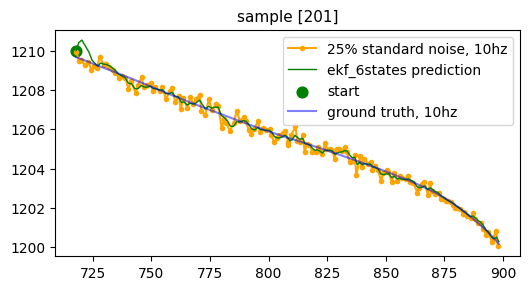

In [332]:
sample = 201
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(rl_seg_pred[sample]['y_noise'], rl_seg_pred[sample]['x_noise'], '-o', label='25% standard noise, 10hz', ms=3, c='orange')
plt.plot(rl_seg_pred[sample]['y_est'], rl_seg_pred[sample]['x_est'], '-', linewidth=1, label='ekf_6states prediction', c='green')
plt.scatter(rl_seg_pred[sample]['y_est'][0], rl_seg_pred[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(rl_seg_pred[sample]['y'], rl_seg_pred[sample]['x'], label='ground truth, 10hz', c='blue', alpha=0.5)
plt.title(f'sample [{sample}]', fontsize=11)
plt.legend()
plt.show()

### more error metrics

In [333]:
pred_err = []
noise_err = []

for j in np.arange(len(rl_seg_pred)):

    x_gt = rl_seg_pred[j]['x'].values
    y_gt = rl_seg_pred[j]['y'].values
    x_est = rl_seg_pred[j]['x_est'].values
    y_est = rl_seg_pred[j]['y_est'].values
    x_noise = rl_seg_pred[j]['x_noise'].values
    y_noise = rl_seg_pred[j]['y_noise'].values

    for i in np.arange(rl_seg_pred[0].shape[0]):
        pred_coord = (x_est[i], y_est[i])
        gt_coord = (x_gt[i], y_gt[i])
        noise_coord = (x_noise[i], y_noise[i])
        
        pred_err.append(math.dist(pred_coord, gt_coord)) # meter
        noise_err.append(math.dist(noise_coord, gt_coord)) # meter

Text(0.5, 0, 'ekf_6states pred error')

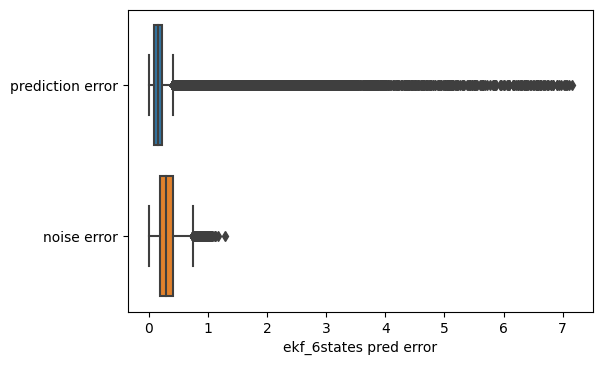

In [367]:
ax = sns.boxplot(data=[
    pred_err, noise_err
], orient='h')
ax.set_yticks([0, 1], ['prediction error', 'noise error'])
plt.xlabel('ekf_6states pred error')

Text(0.5, 0, 'ekf_6states pred error')

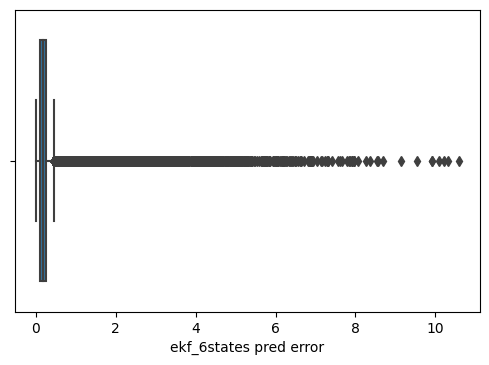

In [99]:
sns.boxplot(pred_err)
plt.xlabel('ekf_6states pred error')

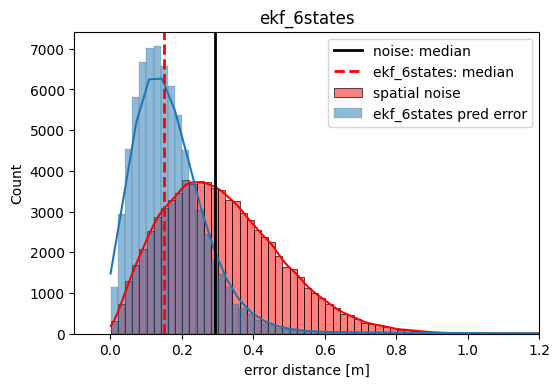

In [351]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    binwidth=0.02, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    binwidth=0.02, label='ekf_6states pred error', kde=True)

ax.axvline(np.median(noise_err), color='k', lw=2, label='noise: median')
ax.axvline(np.nanmedian(np.array(pred_err)), color='red', ls='--', lw=2, label='ekf_6states: median')

plt.title('ekf_6states')
plt.xlabel('error distance [m]')
plt.xlim([-0.1, 1.2])
plt.legend()
plt.show()

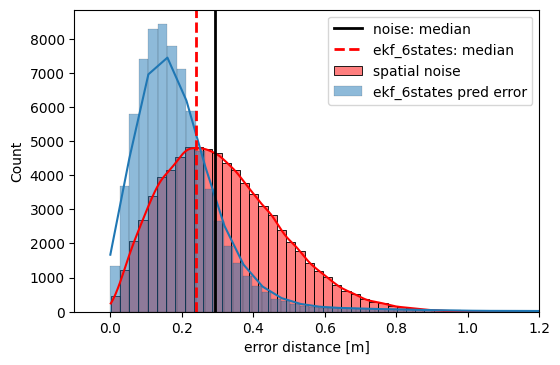

In [125]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    bins=50, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    bins=400, label='ekf_6states pred error', kde=True)

ax.axvline(np.median(noise_err), color='k', lw=2, label='noise: median')
ax.axvline(np.nanmean(np.array(pred_err)), color='red', ls='--', lw=2, label='ekf_6states: median')

plt.xlabel('error distance [m]')
plt.xlim([-0.1, 1.2])
plt.legend()
plt.show()

In [341]:
# batch rmse
rmse_lst = []

for seg_df in rl_seg_pred:
    traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
    traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])

    rmse_lst.append(np.sqrt(mean_squared_error(traj_est_sample, traj_ground_truth)))

np.average(rmse_lst)

In [337]:
length_m_lst = []
length_m_pred_lst = []
length_m_noise_lst = []

for df in tqdm(rl_seg_pred):
    length_m, length_m_pred, length_m_noise = traj_distances_proj(df)
    length_m_lst.append(length_m)
    length_m_pred_lst.append(length_m_pred)
    length_m_noise_lst.append(length_m_noise)

100%|██████████| 500/500 [00:32<00:00, 15.19it/s]


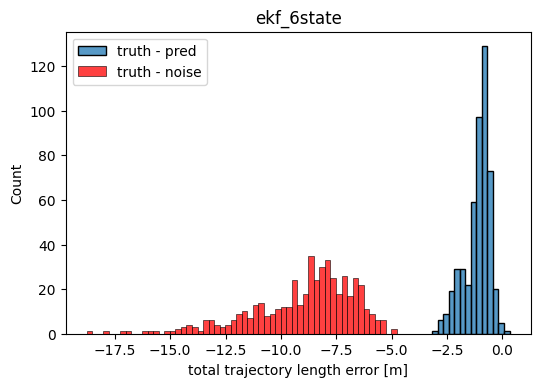

In [338]:
plt.figure(dpi=100)
sns.histplot(np.array(length_m_lst) - np.array(length_m_pred_lst), binwidth=0.25, label='truth - pred')
sns.histplot(np.array(length_m_lst) - np.array(length_m_noise_lst), binwidth=0.25, label='truth - noise', color='red')
plt.title('ekf_6state')
plt.xlabel('total trajectory length error [m]')
plt.legend()

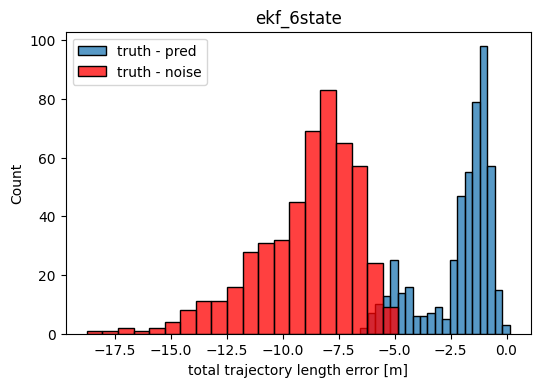

In [126]:
plt.figure(dpi=100)
sns.histplot(np.array(length_m_lst) - np.array(length_m_pred_lst), label='truth - pred')
sns.histplot(np.array(length_m_lst) - np.array(length_m_noise_lst), label='truth - noise', color='red')
plt.title('ekf_6state')
plt.xlabel('total trajectory length error [m]')
plt.legend()

## ekf_6states tuning

#### exp0: model tuned results

In [11]:
# subsample for parameter learning
random.seed(0)
sample_trajs = random.sample(rl_seg_noise, 50)
len(sample_trajs)

In [39]:
# 100 samples, runtime = ~ 10s
# total 500 sample, runtime = ~ 1min

ekf_seg_pred = ekf_batch_eval(rl_seg_noise, param=None) # all samples
# ekf_seg_pred = ekf_batch_eval(sample_trajs, param=None)
len(ekf_seg_pred)

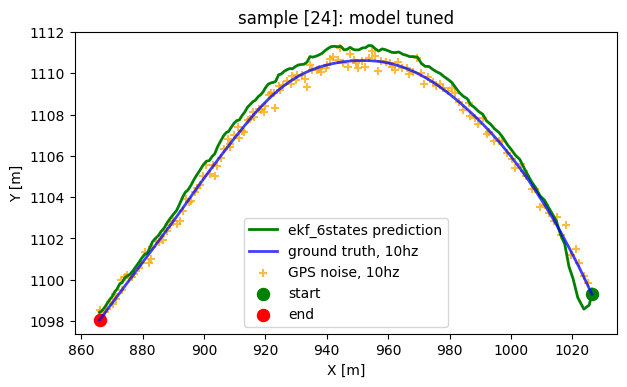

In [40]:
plot_traj_comp_idx(ekf_seg_pred, sample_idx=24, exp_name='model tuned')

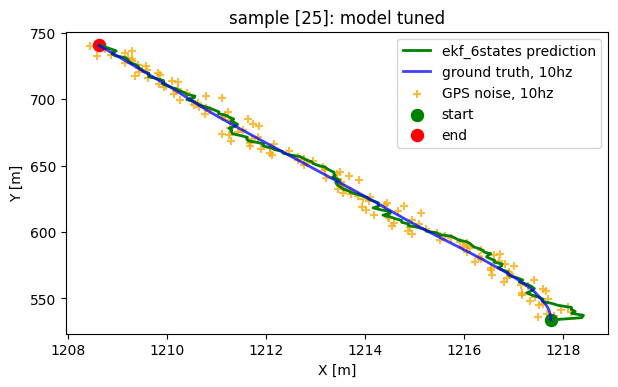

In [88]:
plot_traj_comp_idx(ekf_seg_pred, sample_idx=25, exp_name='model tuned')

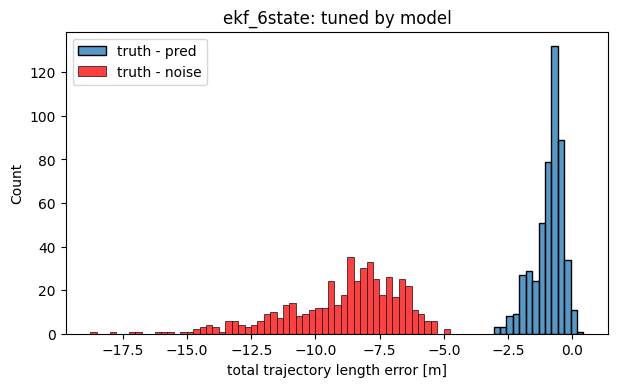

In [290]:
plot_tot_traj_dist_err(ekf_seg_pred, exp_name='tuned by model')

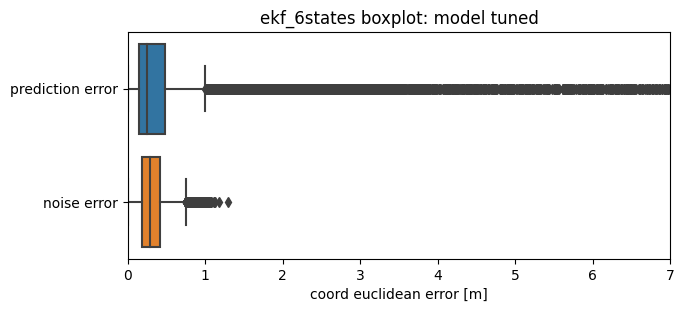

In [22]:
exp0_proj_dist_err_pred, exp0_proj_dist_err_noise = proj_dist_err(ekf_seg_pred)
boxplot_proj_dist_err(exp0_proj_dist_err_pred, exp0_proj_dist_err_noise, exp_name='model tuned')

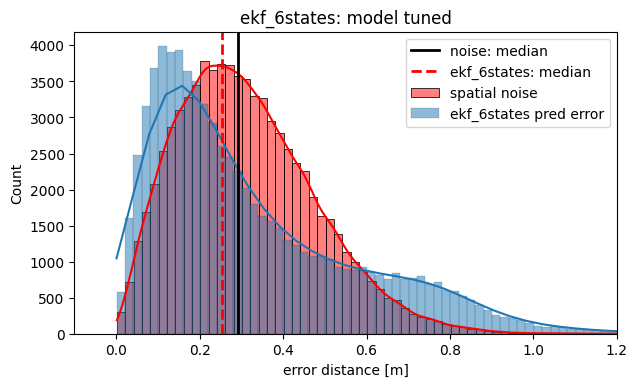

In [23]:
plot_proj_dist_err(exp0_proj_dist_err_pred, exp0_proj_dist_err_noise, exp_name='model tuned')

### loss functions

In [30]:
def batch_gc_dist(space):

    # ekf_results = ekf_batch_eval(batch_df=sample_trajs, param=space) # subsample
    ekf_results = ekf_batch_eval(batch_df=rl_seg_noise, param=space) # full sample
    gc_err_lst = []

    for seg_df in ekf_results:
        traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
        traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])
        traj_gc_err_lst = []

        for i in np.arange(len(seg_df)):
            est_coord = (traj_est[0][i], traj_est[1][i]) 
            gt_coord = (traj_gt[0][i], traj_gt[1][i])
            traj_gc_err_lst.append(math.dist(est_coord, gt_coord))

        gc_err_lst.append(sum(traj_gc_err_lst))
    
    return np.average(gc_err_lst)


def batch_gc_dist_post(ekf_results):

    gc_err_lst = []

    for seg_df in ekf_results:
        traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
        traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])
        traj_gc_err_lst = []

        for i in np.arange(len(seg_df)):
            est_coord = (traj_est[0][i], traj_est[1][i]) 
            gt_coord = (traj_gt[0][i], traj_gt[1][i])
            traj_gc_err_lst.append(math.dist(est_coord, gt_coord))

        gc_err_lst.append(sum(traj_gc_err_lst))
    
    return np.average(gc_err_lst)

In [57]:
def batch_tot_dist(space):

    # ekf_results = ekf_batch_eval(batch_df=sample_trajs, param=space) # subsample
    ekf_results = ekf_batch_eval(batch_df=rl_seg_noise, param=space) # full sample
    total_traj_err_lst = []

    for seg_df in ekf_results:
        
        # total trajectory length
        traj_length, traj_length_pred, _ = traj_distances_proj(seg_df)
        total_traj_err_lst.append(abs(traj_length - traj_length_pred))
    
    return np.average(total_traj_err_lst)

def batch_tot_dist_post(ekf_results):

    total_traj_err_lst = []

    for seg_df in ekf_results:
        traj_length, traj_length_pred, _ = traj_distances_proj(seg_df)
        total_traj_err_lst.append(abs(traj_length - traj_length_pred))
    
    return np.average(total_traj_err_lst)

In [58]:
def batch_rmse(space):
    
    # ekf_results = ekf_batch_eval(batch_df=sample_trajs, param=space) # subsample
    ekf_results = ekf_batch_eval(batch_df=rl_seg_noise, param=space) # full sample
    rmse_lst = []

    for seg_df in ekf_results:
        traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
        traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])

        rmse_lst.append(np.sqrt(mean_squared_error(traj_est, traj_gt)))
    
    return np.average(rmse_lst)

def batch_rmse_post(ekf_results):

    rmse_lst = []

    for seg_df in ekf_results:
        traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
        traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])

        rmse_lst.append(np.sqrt(mean_squared_error(traj_est, traj_gt)))
    
    return np.average(rmse_lst)

In [78]:
def batch_tot_dist_and_rmse(space):
    
    # partial sample
    # ekf_results = ekf_batch_eval(batch_df=sample_trajs, param=space)
    # full sample
    ekf_results = ekf_batch_eval(batch_df=rl_seg_noise, param=space)

    rmse_lst = []
    total_traj_err_lst = []

    for seg_df in ekf_results:
        # coordinate-wise
        traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
        traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])
        # total length
        traj_length, traj_length_pred, _ = traj_distances_proj(seg_df)

        rmse_lst.append(np.sqrt(mean_squared_error(traj_est, traj_gt)))
        total_traj_err_lst.append(abs(traj_length - traj_length_pred))
    
    # normalize both error metrics
    rmse_lst = normalize(np.array([rmse_lst]))[0]
    total_traj_err_lst = normalize(np.array([total_traj_err_lst]))[0]
    comb_err_lst = rmse_lst + total_traj_err_lst

    return np.average(np.array(comb_err_lst))


def batch_tot_dist_and_rmse_post(ekf_results):

    rmse_lst = []
    total_traj_err_lst = []

    for seg_df in ekf_results:
        # coordinate-wise
        traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
        traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])
        # total length
        traj_length, traj_length_pred, _ = traj_distances_proj(seg_df)

        rmse_lst.append(np.sqrt(mean_squared_error(traj_est, traj_gt)))
        total_traj_err_lst.append(abs(traj_length - traj_length_pred))
    
    # normalize both error metrics
    rmse_lst = normalize(np.array([rmse_lst]))[0]
    total_traj_err_lst = normalize(np.array([total_traj_err_lst]))[0]
    comb_err_lst = rmse_lst + total_traj_err_lst

    return np.average(np.array(comb_err_lst))


### hyperopt tuning experiments

In [28]:
def hypeopt_tune(space, err_func, iterations):

    trials = Trials()
    best = fmin(
        fn=err_func,                        # function to optimize
        space=space, 
        algo=tpe.suggest,                   # optimization algorithm, hyperotp will select its parameters automatically
        max_evals=iterations,               # maximum number of iterations
        trials=trials,                      # logging
        rstate=np.random.default_rng(12)    # fixing random state for the reproducibility
    )

    return trials, best

#### hyperopt space

In [29]:
space = {
    'p_diag': hp.uniform('p_diag', 0, 10),
    'q11': hp.uniform('q11', 0, 0.005),
    'q33': hp.uniform('q33', 0, 0.2),
    'q44': hp.uniform('q44', 0, 0.3),
    'q55': hp.uniform('q55', 0, 0.1),
    'q66': hp.uniform('q66', 0, 0.2)
}

#### exp1: using coordinate-wise euclidean error

In [31]:
exp1_trials, exp1_best = hypeopt_tune(space, batch_gc_dist, iterations=50)

100%|██████████| 50/50 [59:39<00:00, 71.59s/trial, best loss: 29.77359289965764]  


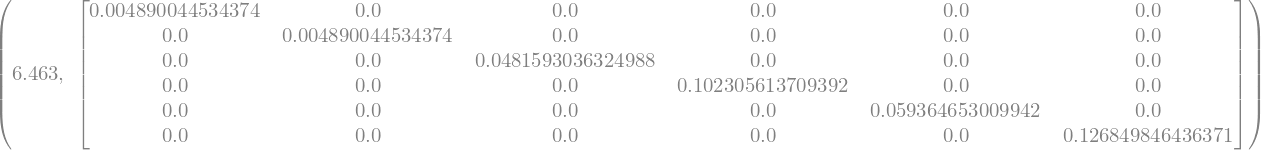

In [46]:
P_diag = exp1_best['p_diag']
Q = np.diag([
        exp1_best['q11'], exp1_best['q11'], exp1_best['q33'], 
        exp1_best['q44'], exp1_best['q55'], exp1_best['q66']
    ])

round(P_diag, 3), Matrix(Q)

In [67]:
P_diag = 6.463
Q = np.diag([
    0.004890044534374, 0.004890044534374, 0.0481593036324988, 
    0.102305613709392, 0.059364653009942, 0.126849846436371
])

In [49]:
# 50 samples, runtime ~= 15s
# exp1_seg_pred = ekf_batch_eval(sample_trajs, exp1_best) # predict with subsample
exp1_seg_pred = ekf_batch_eval(rl_seg_noise, exp1_best[1]) # predict  with full sample

print('exp1 error stats:')
print(f'avg total traj coordinate great circle error, \
      exp0={batch_gc_dist_post(ekf_seg_pred)}, exp1={batch_gc_dist_post(exp1_seg_pred)} [m]')

print(f'avg total segment length error, \
      exp0={batch_tot_dist_post(ekf_seg_pred)}, exp1={batch_tot_dist_post(exp1_seg_pred)} [m]')

print(f'avg RMSE, \
      exp0={batch_rmse_post(ekf_seg_pred)}, exp1={batch_rmse_post(exp1_seg_pred)} [m]')

exp1 error stats:
avg total traj coordinate great circle error,       exp0=59.86110801647576, exp1=30.078205871760424 [m]
avg total segment length error,       exp0=0.9366740454310868, exp1=1.8264357140504426 [m]
avg RMSE,       exp0=0.33527394603108884, exp1=0.20569804254616536 [m]


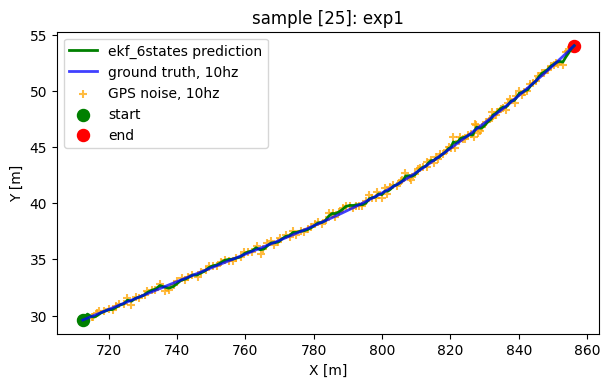

In [50]:
plot_traj_comp_idx(exp1_seg_pred, sample_idx=25, exp_name='exp1')

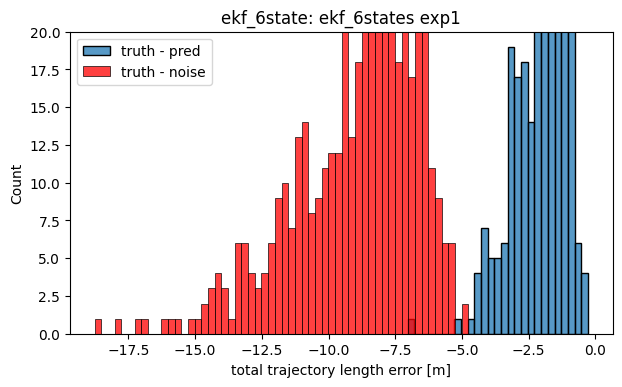

In [51]:
plot_tot_traj_dist_err(exp1_seg_pred, exp_name='ekf_6states exp1')

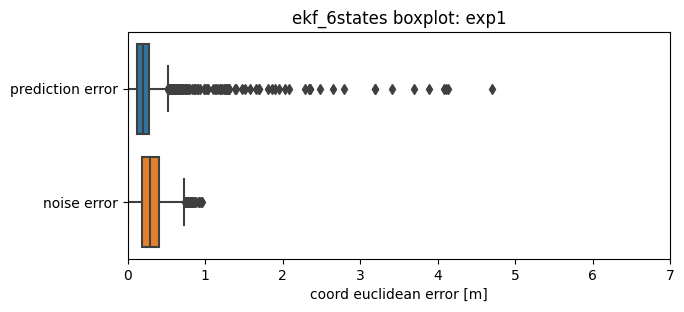

In [74]:
exp1_proj_dist_err_pred, exp1_proj_dist_err_noise = proj_dist_err(exp1_seg_pred)

boxplot_proj_dist_err(exp1_proj_dist_err_pred, exp1_proj_dist_err_noise, exp_name='exp1')

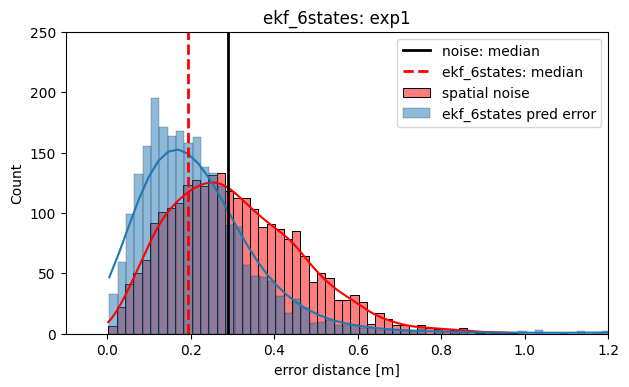

In [79]:
plot_proj_dist_err(exp1_proj_dist_err_pred, exp1_proj_dist_err_noise, exp_name='exp1')

#### exp2: using total trajectory length error

In [52]:
exp2_trials, exp2_best = hypeopt_tune(space, batch_tot_dist, iterations=50)

100%|██████████| 50/50 [08:38<00:00, 10.37s/trial, best loss: 1.1842658411401974]


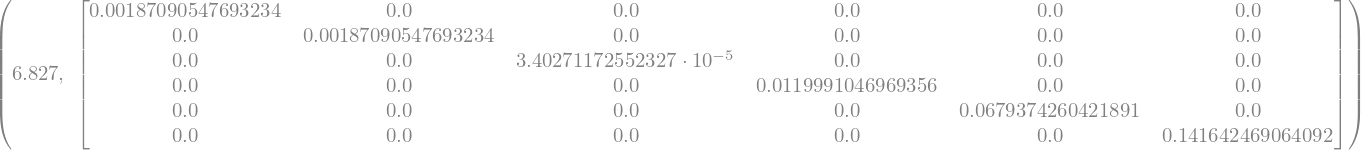

In [25]:
P_diag = exp2_best['p_diag']
Q = np.diag([
        exp2_best['q11'], exp2_best['q11'], exp2_best['q33'], 
        exp2_best['q44'], exp2_best['q55'], exp2_best['q66']
    ])

round(P_diag, 3), Matrix(Q)

In [61]:
# 50 samples, runtime ~= 15s
# 500 samples, runtime ~= 1min

exp2_seg_pred = ekf_batch_eval(rl_seg_noise, exp2_best)

In [86]:
pickle.dump(exp2_trials, open("../models/hyperopt_trials/exp2_500_trials.pkl", "wb"))

In [62]:
print('exp2 error stats:')
print(f'avg total traj coordinate great circle error, \
      exp0={batch_gc_dist_post(ekf_seg_pred)}, exp2={batch_gc_dist_post(exp2_seg_pred)} [m]')

print(f'avg total segment length error, \
      exp0={batch_tot_dist_post(ekf_seg_pred)}, exp2={batch_tot_dist_post(exp2_seg_pred)} [m]')

print(f'avg RMSE, \
      exp0={batch_rmse_post(ekf_seg_pred)}, exp2={batch_rmse_post(exp2_seg_pred)} [m]')

exp2 error stats:
avg total traj coordinate great circle error,       exp0=59.86110801647576, exp2=31.841485273160774 [m]
avg total segment length error,       exp0=0.9366740454310868, exp2=1.1658011268246062 [m]
avg RMSE,       exp0=0.33527394603108884, exp2=0.22803213915737502 [m]


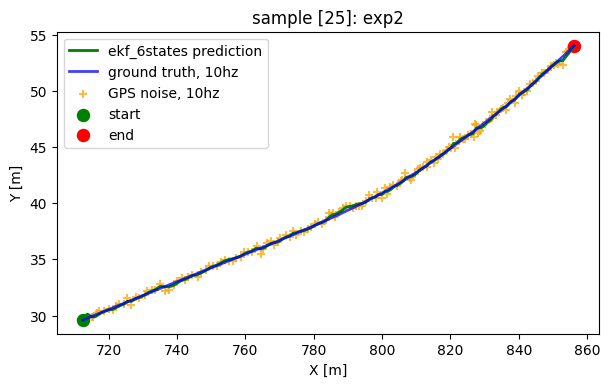

In [63]:
plot_traj_comp_idx(exp2_seg_pred, sample_idx=25, exp_name='exp2')

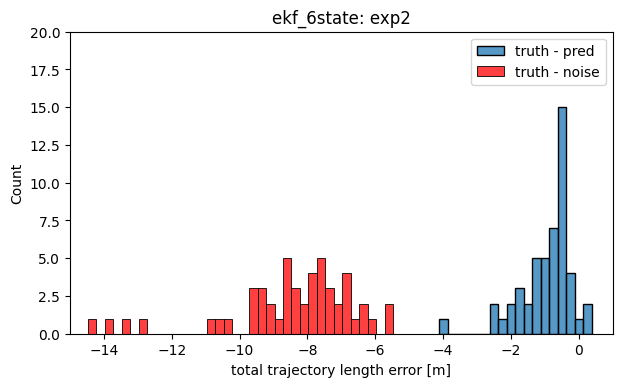

In [91]:
plot_tot_traj_dist_err(exp2_seg_pred, exp_name='exp2')

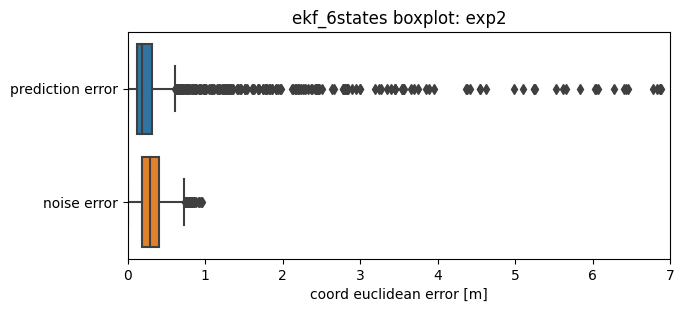

In [103]:
exp2_proj_dist_err_pred, exp2_proj_dist_err_noise = proj_dist_err(exp2_seg_pred)
boxplot_proj_dist_err(exp2_proj_dist_err_pred, exp2_proj_dist_err_noise, exp_name='exp2')

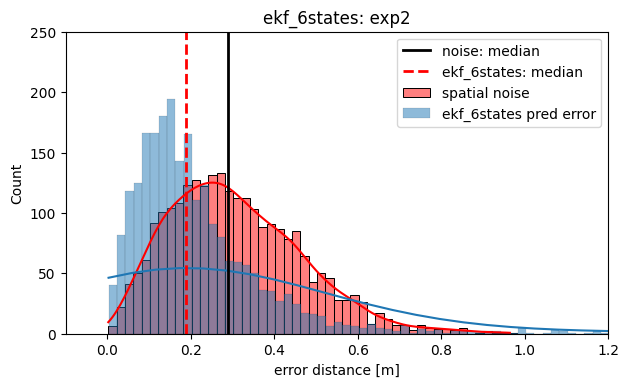

In [94]:
plot_proj_dist_err(exp2_proj_dist_err_pred, exp2_proj_dist_err_noise, exp_name='exp2')

#### exp3: using trajectory rmse

In [59]:
# 50 samples, 75 iterations = 9min
# 100 samples, 50 iterations = 5min
# 500 samples, 50 iterations = 64min
exp3_trials, exp3_best = hypeopt_tune(space, batch_rmse, iterations=50)

100%|██████████| 50/50 [1:04:46<00:00, 77.73s/trial, best loss: 0.18936805402674206]


In [75]:
pickle.dump(exp3_trials, open("../models/hyperopt_trials/exp3_500_trials.pkl", "wb"))

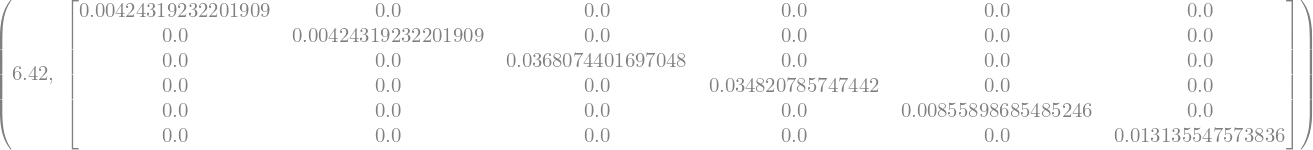

In [206]:
P_diag_exp3 = exp3_best['p_diag']
P_exp3 = P_diag_exp3 * np.eye(len(state))
Q_exp3 = np.diag([
        exp3_best['q11'], exp3_best['q11'], exp3_best['q33'],
        exp3_best['q44'], exp3_best['q55'], exp3_best['q66']
    ])

np.save('../data/ekf_param/exp3_rmse/P_exp3_100seg_50iter.npy', P_exp3)
np.save('../data/ekf_param/exp3_rmse/Q_exp3_100seg_50iter.npy', Q_exp3)

round(P_diag_exp3, 3), Matrix(Q_exp3)

In [64]:
# 50 samples, runtime ~= 15s
# 100 samples, runtime ~= 15s
# 500 samples, runtime ~= 1min 20s

exp3_seg_pred = ekf_batch_eval(rl_seg_noise, exp3_best)

In [65]:
print('exp3 error stats:')
print(f'avg total traj coordinate great circle error, \
      exp0={batch_gc_dist_post(ekf_seg_pred)}, exp3={batch_gc_dist_post(exp3_seg_pred)} [m]')

print(f'avg total segment length error, \
      exp0={batch_tot_dist_post(ekf_seg_pred)}, exp3={batch_tot_dist_post(exp3_seg_pred)} [m]')

print(f'avg RMSE, \
      exp0={batch_rmse_post(ekf_seg_pred)}, exp3={batch_rmse_post(exp3_seg_pred)} [m]')

exp3 error stats:
avg total traj coordinate great circle error,       exp0=59.86110801647576, exp3=31.611841541648836 [m]
avg total segment length error,       exp0=0.9366740454310868, exp3=3.242926082346337 [m]
avg RMSE,       exp0=0.33527394603108884, exp3=0.18936805402674206 [m]


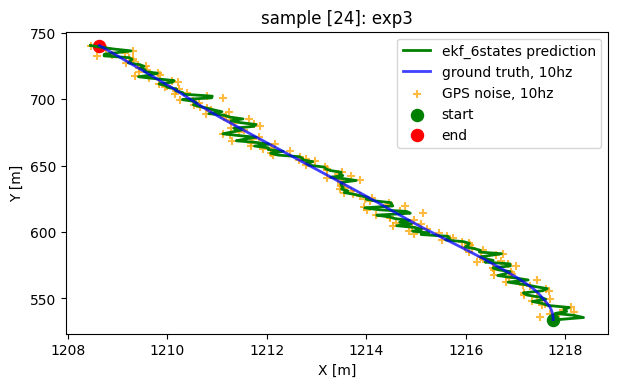

In [229]:
plot_traj_comp_idx(exp3_seg_pred, sample_idx=24, exp_name='exp3')

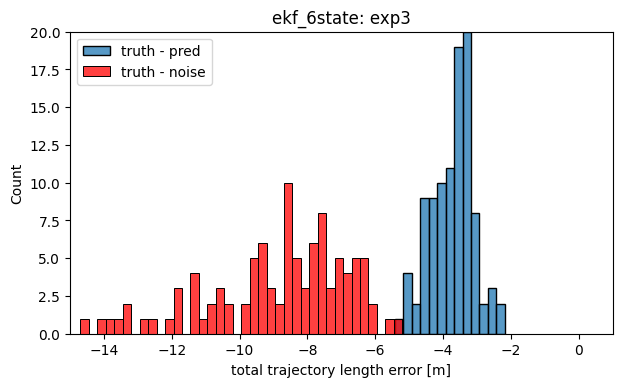

In [230]:
plot_tot_traj_dist_err(exp3_seg_pred, exp_name='exp3')

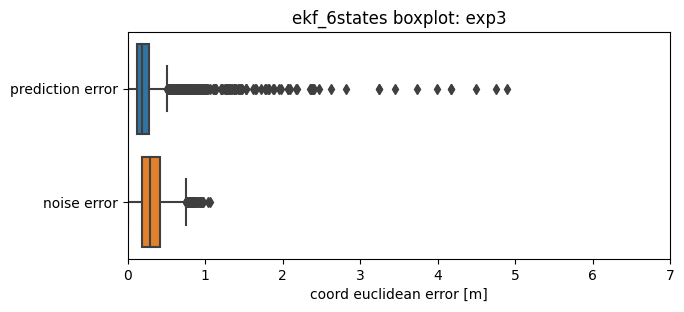

In [231]:
exp3_proj_dist_err_pred, exp3_proj_dist_err_noise = proj_dist_err(exp3_seg_pred)
boxplot_proj_dist_err(exp3_proj_dist_err_pred, exp3_proj_dist_err_noise, exp_name='exp3')

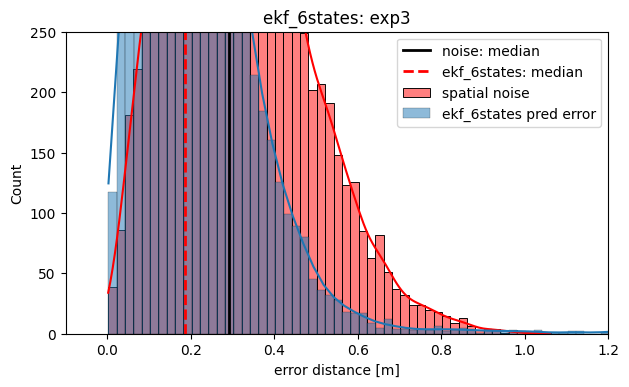

In [232]:
plot_proj_dist_err(exp3_proj_dist_err_pred, exp3_proj_dist_err_noise, exp_name='exp3')

#### exp4: using combined trajectory RMSE and total trajectory length error

In [66]:
# 100 samples, 75 iterations. runtime ~= 23min
# 500 samples, 50 iteration, runtime ~= 59min
# exp4_best = hypeopt_tune(space, batch_tot_dist_and_rmse, 75)
exp4_trials, exp4_best = hypeopt_tune(space, batch_tot_dist_and_rmse, 50)

100%|██████████| 50/50 [1:29:47<00:00, 107.74s/trial, best loss: 0.03077386464521842]


In [68]:
# 50 samples, runtime ~= 15s
# 100 samples, runtime ~= 15s
# 500 samples, runtime ~= 

# exp4_seg_pred = ekf_batch_eval(sample_trajs, exp4_best)
exp4_seg_pred = ekf_batch_eval(rl_seg_noise, exp4_best[1])

In [84]:
pickle.dump(exp4_best[0], open("../models/hyperopt_trials/exp4_500_trials.pkl", "wb"))

In [83]:
print('exp4 error stats:')
print(f'avg total traj coordinate great circle error, \
      exp0={batch_gc_dist_post(ekf_seg_pred)}, exp4={batch_gc_dist_post(exp4_seg_pred)} [m]')

print(f'avg total segment length error, \
      exp0={batch_tot_dist_post(ekf_seg_pred)}, exp4={batch_tot_dist_post(exp4_seg_pred)} [m]')

print(f'avg RMSE, \
      exp0={batch_rmse_post(ekf_seg_pred)}, exp4={batch_rmse_post(exp4_seg_pred)} [m]')

exp4 error stats:
avg total traj coordinate great circle error,       exp0=59.86110801647576, exp4=37.53404228824153 [m]
avg total segment length error,       exp0=0.9366740454310868, exp4=2.363609400580936 [m]
avg RMSE,       exp0=0.33527394603108884, exp4=0.25679001676884344 [m]


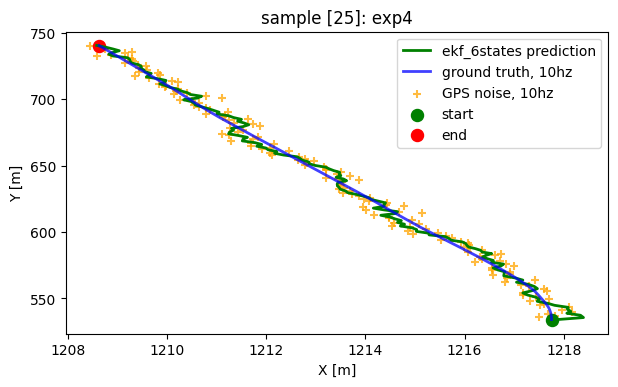

In [52]:
plot_traj_comp_idx(exp4_seg_pred, sample_idx=25, exp_name='exp4')

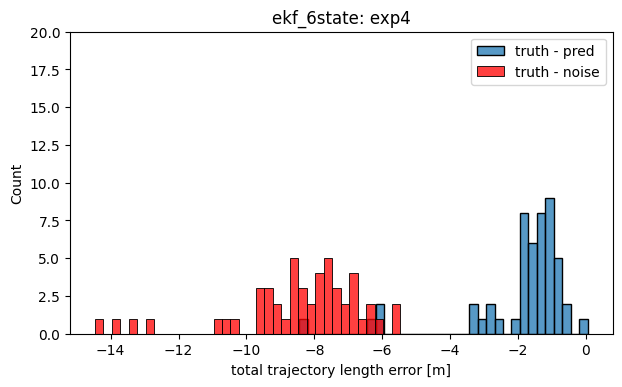

In [55]:
plot_tot_traj_dist_err(exp4_seg_pred, exp_name='exp4')

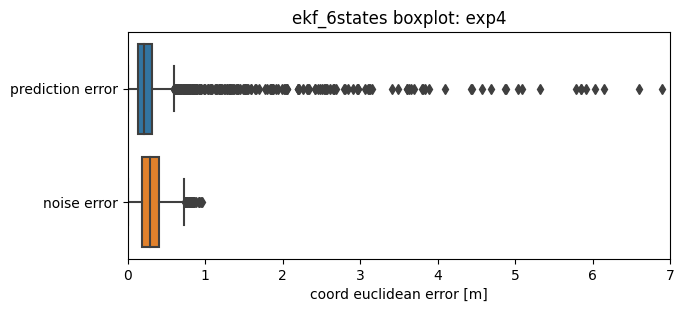

In [35]:
exp4_proj_dist_err_pred, exp4_proj_dist_err_noise = proj_dist_err(exp4_seg_pred)
boxplot_proj_dist_err(exp4_proj_dist_err_pred, exp4_proj_dist_err_noise, exp_name='exp4')

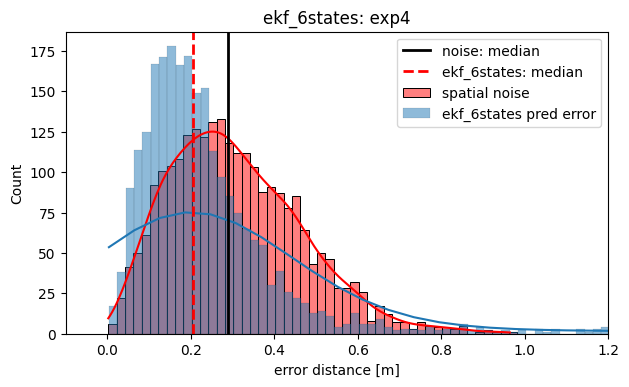

In [36]:
plot_proj_dist_err(exp4_proj_dist_err_pred, exp4_proj_dist_err_noise, exp_name='exp4')

#### exp5: using combined error with additional measurement covariance terms

In [77]:
# uniform search space

space_v2 = {
    'p_diag': hp.uniform('p_diag', 0, 10),
    'q11': hp.uniform('q11', 0, 0.005),
    'q33': hp.uniform('q33', 0, 0.2),
    'q44': hp.uniform('q44', 0, 0.3),
    'q55': hp.uniform('q55', 0, 0.1),
    'q66': hp.uniform('q66', 0, 0.2),
    'r44': hp.uniform('r44', 0, 1),
    'r55': hp.uniform('r55', 0, 1),
}

In [80]:
# 50 samples, runtime ~= 9min
# 100 samples, runtime ~= 17min
# 500 samples, runtime ~= 126min
exp5_trials, exp5_best = hypeopt_tune(space_v2, batch_tot_dist_and_rmse, iterations=75)

21                                                    
100%|██████████| 75/75 [2:08:01<00:00, 102.42s/trial, best loss: 0.08246781646097687]  


In [81]:
# 100 samples, runtime ~= 15s
exp5_seg_pred = ekf_batch_eval(sample_trajs, exp5_best)

In [85]:
pickle.dump(exp5_trials, open("../models/hyperopt_trials/exp5_500_trials.pkl", "wb"))

In [82]:
print('exp5 error stats:')
print(f'avg total traj coordinate great circle error, \
      exp0={batch_gc_dist_post(ekf_seg_pred)}, exp5={batch_gc_dist_post(exp5_seg_pred)} [m]')

print(f'avg total segment length error, \
      exp0={batch_tot_dist_post(ekf_seg_pred)}, exp5={batch_tot_dist_post(exp5_seg_pred)} [m]')

print(f'avg RMSE, \
      exp0={batch_rmse_post(ekf_seg_pred)}, exp5={batch_rmse_post(exp5_seg_pred)} [m]')

exp5 error stats:
avg total traj coordinate great circle error,       exp0=59.86110801647576, exp5=31.771718162858168 [m]
avg total segment length error,       exp0=0.9366740454310868, exp5=2.5287675085879924 [m]
avg RMSE,       exp0=0.33527394603108884, exp5=0.20859460014360373 [m]


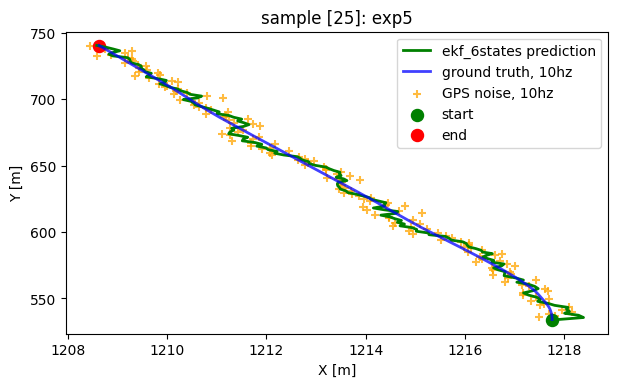

In [43]:
plot_traj_comp_idx(exp5_seg_pred, sample_idx=25, exp_name='exp5')

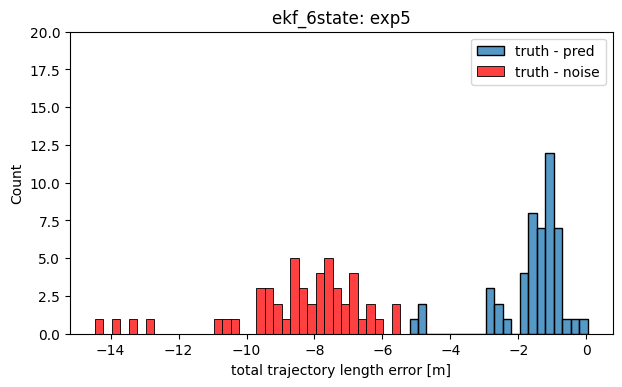

In [56]:
plot_tot_traj_dist_err(exp5_seg_pred, exp_name='exp5')

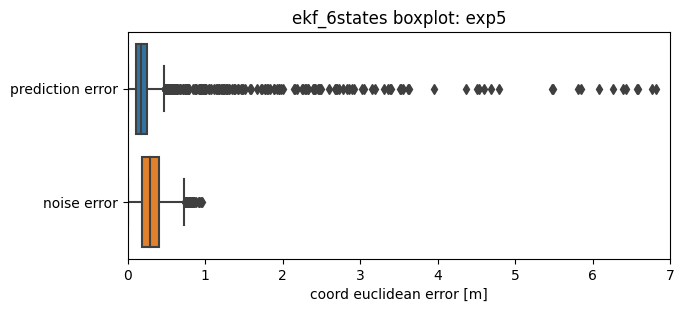

In [45]:
exp5_proj_dist_err_pred, exp5_proj_dist_err_noise = proj_dist_err(exp5_seg_pred)
boxplot_proj_dist_err(exp5_proj_dist_err_pred, exp5_proj_dist_err_noise, exp_name='exp5')

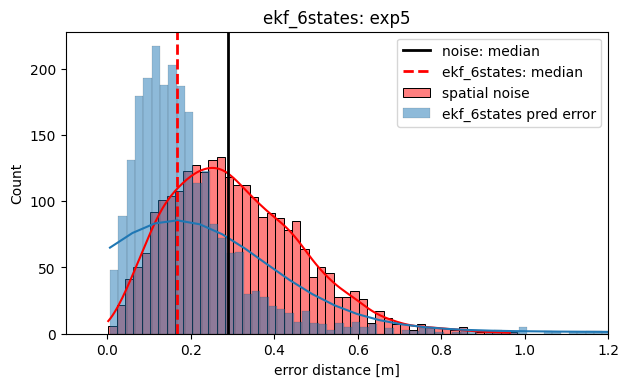

In [46]:
plot_proj_dist_err(exp5_proj_dist_err_pred, exp5_proj_dist_err_noise, exp_name='exp5')

#### exp6: Savitzky-Golay filter
adding the Savitzky-Golay filter as a preprocessing step to the acceleration and angular rate data 

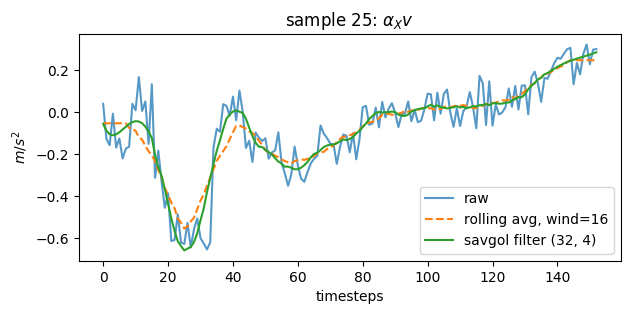

In [191]:
plt.figure(dpi=100, figsize=(7, 3))

sample_idx = 25
plt.plot(sample_trajs[sample_idx]['alpha_Xv'].values, label='raw', alpha=0.75)
plt.plot(savgol_filter(sample_trajs[sample_idx]['alpha_Xv'].values, 16, 0), '--', label='rolling avg, wind=16')
# plt.plot(savgol_filter(sample_trajs[sample_idx]['alpha_Xv'].values, 8, 2), label='savgol filter (8, 2)')
# plt.plot(savgol_filter(sample_trajs[sample_idx]['alpha_Xv'].values, 8, 2), label='savgol filter (8, 2)')
plt.plot(savgol_filter(sample_trajs[sample_idx]['alpha_Xv'].values, 32, 4), label='savgol filter (32, 4)')

plt.ylabel(r'$m/s^2$')
plt.xlabel('timesteps')
plt.title(fr'sample {sample_idx}: $\alpha_Xv$')
plt.legend()
plt.show()

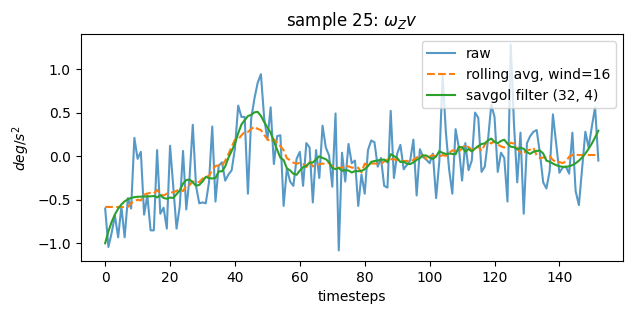

In [202]:
plt.figure(dpi=100, figsize=(7, 3))

sample_idx = 25
plt.plot(sample_trajs[sample_idx]['omega_Zv'].values, label='raw', alpha=0.75)
plt.plot(savgol_filter(sample_trajs[sample_idx]['omega_Zv'].values, 16, 0), '--', label='rolling avg, wind=16')
# plt.plot(savgol_filter(sample_trajs[sample_idx]['omega_Zv'].values, 8, 2), label='savgol filter (8, 2)')
plt.plot(savgol_filter(sample_trajs[sample_idx]['omega_Zv'].values, 32, 4), label='savgol filter (32, 4)')

plt.ylabel(r'$deg/s^2$')
plt.xlabel('timesteps')
plt.title(fr'sample {sample_idx}: $\omega_Zv$')
plt.legend()
plt.show()

In [204]:
# 50 samples, 75 iteration, runtime ~= 9min
# 100 samples, 75 iteration, runtime ~= 17min
exp6_trials, exp6_best = hypeopt_tune(space_v2, batch_tot_dist_and_rmse, iterations=75)

100%|██████████| 75/75 [13:11<00:00, 10.55s/trial, best loss: 0.21673649924730612]


In [93]:
exp6_best

{'p_diag': 2.014720743502354,
 'q11': 0.0028627899342550315,
 'q33': 0.03210535145333435,
 'q44': 0.24231254527377422,
 'q55': 0.0592911957944525,
 'q66': 0.10793147809110992,
 'r44': 0.6998269357379697,
 'r55': 0.17303008908924544}

In [142]:
exp6_best

{'p_diag': 9.55894982471133,
 'q11': 0.0006938904621258648,
 'q33': 0.0016874142380238488,
 'q44': 0.08712447746428627,
 'q55': 0.06687961134957042,
 'q66': 0.1332065428227537,
 'r44': 0.003904487632396536,
 'r55': 0.6068493559975863}

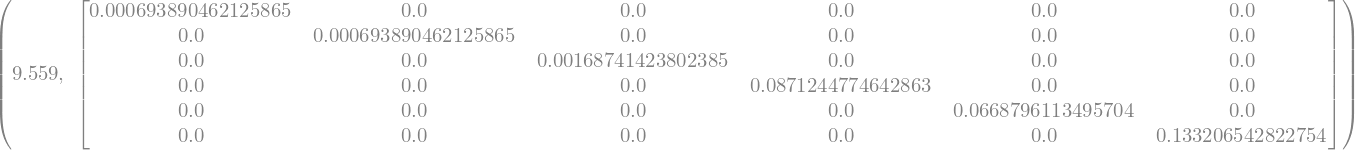

In [143]:
P_diag_exp6 = exp6_best['p_diag']
P_exp6 = P_diag_exp6 * np.eye(len(state))
Q_exp6 = np.diag([
        exp6_best['q11'], exp6_best['q11'], exp6_best['q33'],
        exp6_best['q44'], exp6_best['q55'], exp6_best['q66']
    ])

round(P_diag_exp6, 3), Matrix(Q_exp6)

In [205]:
# 50 samples, rutime ~= 10s
# 100 samples, runtime ~= 15s
exp6_seg_pred = ekf_batch_eval(sample_trajs, exp6_best)

In [206]:
print('exp6 error stats:')
print(f'avg total traj coordinate great circle error, \
      exp0={batch_gc_dist_post(ekf_seg_pred)}, exp6={batch_gc_dist_post(exp6_seg_pred)} [m]')

print(f'avg total segment length error, \
      exp0={batch_tot_dist_post(ekf_seg_pred)}, exp6={batch_tot_dist_post(exp6_seg_pred)} [m]')

print(f'avg RMSE, \
      exp0={batch_rmse_post(ekf_seg_pred)}, exp6={batch_rmse_post(exp6_seg_pred)} [m]')

exp6 error stats:
avg total traj coordinate great circle error,       exp0=70.7556152911295, exp6=32.27525532738207 [m]
avg total segment length error,       exp0=0.9103304097377531, exp6=1.7887676895229885 [m]
avg RMSE,       exp0=0.4014671983881149, exp6=0.2370765689821447 [m]


In [152]:
print('exp6 error stats:')
print(f'avg total traj coordinate great circle error, \
      exp0={batch_gc_dist_post(ekf_seg_pred)}, exp6={batch_gc_dist_post(exp6_seg_pred)} [m]')

print(f'avg total segment length error, \
      exp0={batch_tot_dist_post(ekf_seg_pred)}, exp6={batch_tot_dist_post(exp6_seg_pred)} [m]')

print(f'avg RMSE, \
      exp0={batch_rmse_post(ekf_seg_pred)}, exp6={batch_rmse_post(exp6_seg_pred)} [m]')

exp6 error stats:
avg total traj coordinate great circle error,       exp0=70.7556152911295, exp6=32.27525532738207 [m]
avg total segment length error,       exp0=0.9103304097377531, exp6=1.7887676895229885 [m]
avg RMSE,       exp0=0.4014671983881149, exp6=0.2370765689821447 [m]


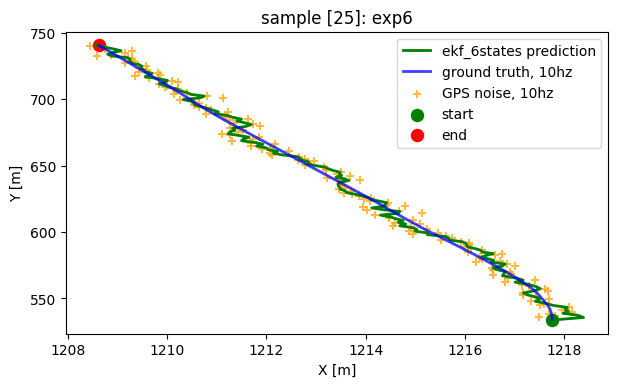

In [207]:
plot_traj_comp_idx(exp6_seg_pred, sample_idx=25, exp_name='exp6')

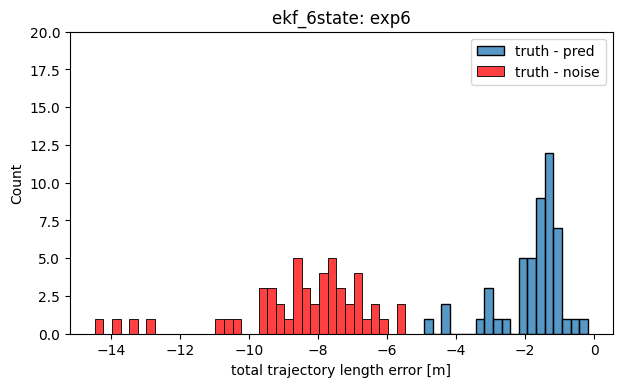

In [209]:
plot_tot_traj_dist_err(exp6_seg_pred, exp_name='exp6')

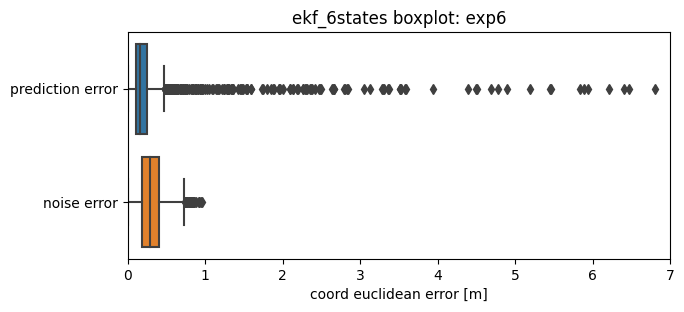

In [210]:
exp6_proj_dist_err_pred, exp6_proj_dist_err_noise = proj_dist_err(exp6_seg_pred)
boxplot_proj_dist_err(exp6_proj_dist_err_pred, exp6_proj_dist_err_noise, exp_name='exp6')

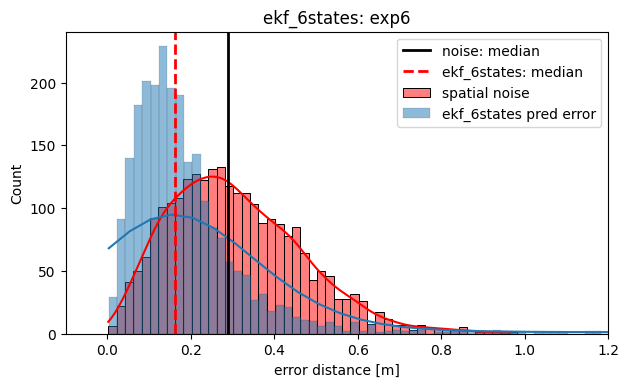

In [211]:
plot_proj_dist_err(exp6_proj_dist_err_pred, exp6_proj_dist_err_noise, exp_name='exp6')

#### exp7: exp6 with full sample fitting
applying Savitzky-Golay filter as preprocessing for the entire sample set, and use the full sample set for parameter fitting.

In [214]:
# 500 samples, 50 iteration, runtime ~= 

exp7_trials, exp7_best = hypeopt_tune(space_v2, batch_tot_dist_and_rmse, iterations=50)

100%|██████████| 50/50 [1:23:19<00:00, 99.99s/trial, best loss: 0.08184571316201485]


In [215]:
# 50 samples, rutime ~= 10s
# 100 samples, runtime ~= 15s
exp7_seg_pred = ekf_batch_eval(sample_trajs, exp7_best)

In [217]:
exp7_best

{'p_diag': 3.4730757444583027,
 'q11': 0.0009129042906468439,
 'q33': 0.00010433830303117203,
 'q44': 0.09806982954110689,
 'q55': 0.0629331825054377,
 'q66': 0.05827693782060471,
 'r44': 0.16410694832769535,
 'r55': 0.8577869139471326}

In [216]:
print('exp7 error stats:')
print(f'avg total traj coordinate great circle error, \
      exp0={batch_gc_dist_post(ekf_seg_pred)}, exp7={batch_gc_dist_post(exp7_seg_pred)} [m]')

print(f'avg total segment length error, \
      exp0={batch_tot_dist_post(ekf_seg_pred)}, exp7={batch_tot_dist_post(exp7_seg_pred)} [m]')

print(f'avg RMSE, \
      exp0={batch_rmse_post(ekf_seg_pred)}, exp7={batch_rmse_post(exp7_seg_pred)} [m]')

exp7 error stats:
avg total traj coordinate great circle error,       exp0=70.7556152911295, exp7=31.816747483097142 [m]
avg total segment length error,       exp0=0.9103304097377531, exp7=2.4093593433400975 [m]
avg RMSE,       exp0=0.4014671983881149, exp7=0.21085382547189557 [m]


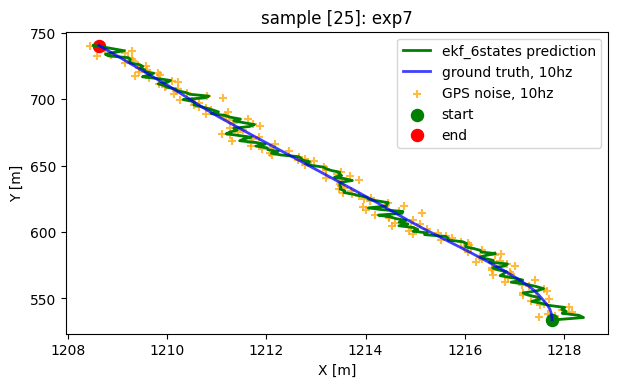

In [218]:
plot_traj_comp_idx(exp7_seg_pred, sample_idx=25, exp_name='exp7')